In [1]:
from os.path import join
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import FactorAnalyzer
import scipy.stats as stats
#plt.style.use("apa.mplstyle") #custom matplotlib style

In [2]:
folder_path = "/data/NewsGuard/full-metadata/"
figures_path = "/home/jluehring/newsguard/newsguard-review-paper/figures/"
tables_path = "/home/jluehring/newsguard/newsguard-review-paper/tables/"

# Dataset construction

In [3]:
csv_files = [f for f in os.listdir(folder_path) \
                if f.endswith(".csv") \
                and "2024" not in f]

df_total = pd.DataFrame()
for csv in csv_files: #taking all files in the folder
    df = pd.read_csv(join(folder_path, csv))
    df.name=csv
    #print(df.shape)
    # taking name of file, removing the extension and "metadata-"
    df["file_date"]=csv.split(".")[0].split("-")[1]
    # converting file_date to datetime, with format YYYYMMDD00
    df["file_date"]=pd.to_datetime(df["file_date"], 
                                   format="%Y%m%d%H")
    df_total = pd.concat([df_total, df], axis=0)

In [4]:
csv_files = [f for f in os.listdir(folder_path) \
                if f.endswith("1501.csv") \
                and "2024" not in f] #taking only mid-month 
df_15 = pd.DataFrame()
for csv in csv_files:
    df = pd.read_csv(join(folder_path, csv))
    df.name=csv
    #print(df.shape)
    df["file_date"]=csv.split(".")[0].split("-")[1]
    df["file_date"]=pd.to_datetime(df["file_date"], 
                                   format="%Y%m%d%H")
    df_15 = pd.concat([df_15, df], axis=0)

In [5]:
csv_files = [f for f in os.listdir(folder_path) \
                if f.endswith("0201.csv") \
                and "2024" not in f] 
df_02 = pd.DataFrame()
for csv in csv_files:
    df = pd.read_csv(join(folder_path, csv))
    df.name=csv
    #print(df.shape)
    df["file_date"]=csv.split(".")[0].split("-")[1]
    df["file_date"]=pd.to_datetime(df["file_date"], 
                                   format="%Y%m%d%H")
    df_02 = pd.concat([df_02, df], axis=0)

In [6]:
df_recent = df_15[df_15["file_date"] == df_15["file_date"].max()]
df_first = df_15[df_15["file_date"] == df_15["file_date"].min()]

print(f'In the most recent file, there are {len(df_recent)} entries, '
      f'with {df_recent["UUID"].nunique()} rating IDs '
      f'and {df_recent["Domain"].nunique()} domains.')

print(f'In the first file, there are {len(df_first)} entries, '
      f'with {df_first["UUID"].nunique()} IDs '
      f'and {df_first["Domain"].nunique()} domains.')

In the most recent file, there are 11314 entries, with 6598 rating IDs and 9946 domains.
In the first file, there are 2647 entries, with 2647 IDs and 2641 domains.


In [7]:
df_recent.columns

Index(['UUID', 'Domain', 'Parent Domain', 'Rating', 'Score', 'Last Updated',
       'Country', 'Language', 'Does not repeatedly publish false content',
       'Gathers and presents information responsibly',
       'Regularly corrects or clarifies errors',
       'Handles the difference between news and opinion responsibly',
       'Avoids deceptive headlines',
       'Website discloses ownership and financing',
       'Clearly labels advertising',
       'Reveals who's in charge, including any possible conflicts of interest',
       'The site provides names of content creators, along with either contact or biographical information',
       'Brand Name', 'Wikipedia', 'Type of Content', 'Medium',
       'Print Publications', 'Scope of Coverage', 'Designated Market Area',
       'Paywall', 'Opinion/Advocacy Journalism', 'Orientation', 'Owner',
       'Type of Owner', 'Facebook', 'Twitter', 'YouTube', 'Instagram',
       'Snapchat', 'LinkedIn', 'Pinterest', 'Main Point of Contact (name)',


In [8]:
rating_counts = df_recent.Rating\
    .value_counts(normalize=False)\
    .reset_index()\
    .rename(columns={"index":"Rating", "Rating":"Count"})

rating_countsp = df_recent.Rating\
    .value_counts(normalize=True)\
    .reset_index()\
    .rename(columns={"index":"Rating", "Rating":"Percent"})

ratings = pd.merge(rating_counts, rating_countsp, 
                   on="Rating")

rating_mean = df_recent\
    .groupby("Rating").Score\
    .mean()\
    .reset_index()\
    .rename(columns={"Score":"Mean"})

pd.merge(ratings, rating_mean, on="Rating")

,Rating,Count,Percent,Mean
0,T,6651,0.587856,87.370320
1,N,4007,0.354163,26.107187
2,FL,530,0.046845,NaN
3,P,63,0.005568,NaN
4,S,63,0.005568,NaN


In [9]:
for rating in df_recent.Rating.unique():
    print(rating, df_recent[df_recent.Rating == rating].Domain.unique()[:3])

T ['peterboroughtoday.co.uk' 'gopdailybrief.com' 'salon.com']
N ['mycharisma.com' 'charismamag.com' 'revolver.news']
FL ['letradamus.es' 'mundodelcafe.es' 'mamamusical.aarg.ar']
P ['youtube.com' 'youtu.be' 'dailymotion.com']
S ['bassesaintonge.fr' 'secretnews.fr' 'chaser.com.au']


In [10]:
p_rating = df_recent[df_recent["Rating"] == "P"]
if not p_rating["Score"].isnull().all():
    mean_score = p_rating["Score"].mean(skipna=True)
    print(f"Mean score for rating P: {mean_score}")
else:
    print(f"No scores available for rating P.")

No scores available for rating P.


In [11]:
print(f'Number of rows without Score: {df_recent.Score.isna().sum()}')
print(f'Percentage: {round(df_recent.Score.isna().sum()/len(df_recent)*100,2)}%')

Number of rows without Score: 656
Percentage: 5.8%


## How volatile are trustworthiness ratings?

### Coverage

In [12]:
print(f'In the most recent df, there are {len(df_recent[df_recent["Score"].notnull()])} '
      f'rated domains while there are {len(df_first[df_first["Score"].notnull()])} '
      'in the first version of the database.')
print(f'The domains belong to {df_recent["Parent Domain"].nunique()} parent domains.')
print(f'The number of entries has grown by {round((len(df_recent)/len(df_first)-1)*100,2)}%')

In the most recent df, there are 10658 rated domains while there are 2615 in the first version of the database.
The domains belong to 403 parent domains.
The number of entries has grown by 327.43%


In [13]:
df_recent["Parent Domain"].notnull().value_counts() #5186 with parent domain, 6128 without

False    6128
True     5186
Name: Parent Domain, dtype: int64

In [14]:
#counting number of ratings for sampling mid-month
counts_15 = df_15.groupby(df_15.file_date)\
    .size()\
    .reset_index(name="Counts")

#counting number of ratings for sampling beginning of month
counts_02 = df_02.groupby(df_02.file_date)\
    .size()\
    .reset_index(name="Counts")

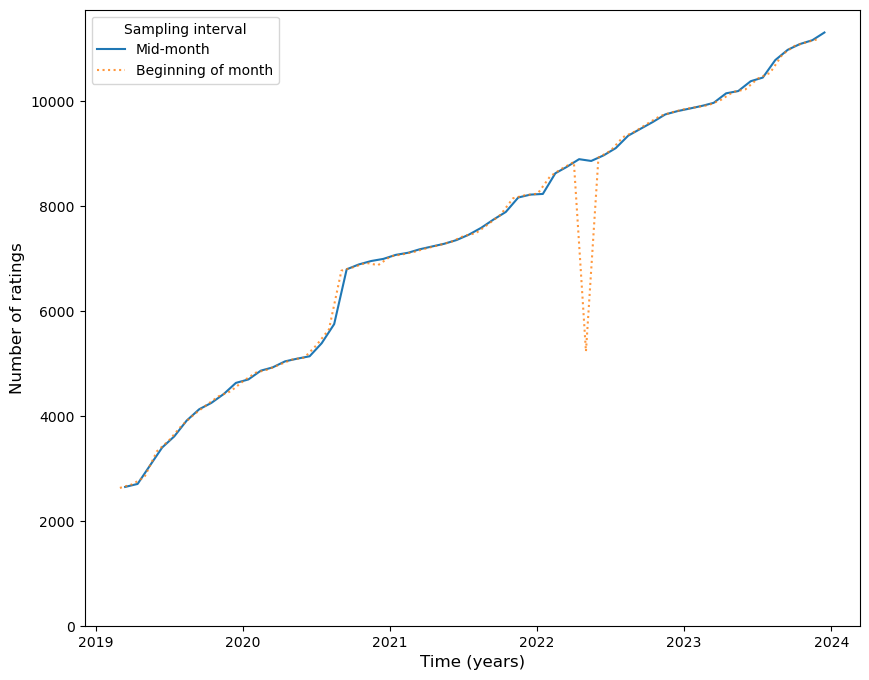

In [15]:
plt.figure(figsize=(10,8))
sns.lineplot(data=counts_15, 
             x="file_date", 
             y="Counts", 
             #color="blue", 
             label="Mid-month")

sns.lineplot(data=counts_02, 
             x="file_date", 
             y="Counts", 
             #color="blue", 
             label="Beginning of month", 
             alpha=0.8, 
             linestyle="dotted")

plt.ylim(0)
plt.xlabel("Time (years)", fontsize=12)
plt.ylabel("Number of ratings", fontsize=12)
plt.legend(title="Sampling interval")
#plt.xticks(rotation=20)
plt.savefig(join(figures_path,
                 "f1-sources_over_time.png"), 
                 dpi=300)
plt.show()

### Added and removed sources

In [16]:
domain_changes = {}
#getting list of unique months to iterate through
unique_months = df_15.sort_values("file_date")["file_date"]\
                    .unique()

for i in range(1, len(unique_months)): #iterate through months
    current_month = unique_months[i] #set as current months
    previous_month = unique_months[i - 1] #set month minus one as previous month
    
    #compare domains from current month to previous month
    added_month = set(df_15[df_15["file_date"] == current_month]["Domain"].tolist())\
        - set(df_15[df_15["file_date"] == previous_month]["Domain"].tolist())
    removed_month = set(df_15[df_15["file_date"] == previous_month]["Domain"].tolist())\
        - set(df_15[df_15["file_date"] == current_month]["Domain"].tolist())
    domain_changes[current_month] = added_month, removed_month

In [17]:
data = []
for date, (added, removed) in domain_changes.items():
    data.append({"Date": date, 
                 "Added": len(added), 
                 "Removed": len(removed)})

domain_changes_df = pd.DataFrame(data)

In [18]:
print(f'Total number of added sources: {domain_changes_df["Added"].sum()}')
print(f'Total number of removed sources: {domain_changes_df["Removed"].sum()}')

Total number of added sources: 7937
Total number of removed sources: 632


In [19]:
print(f'Average number of added sources per month: {domain_changes_df["Added"].mean()}')
print(f'Average number of removed sources per month: {domain_changes_df["Removed"].mean()}')

Average number of added sources per month: 141.73214285714286
Average number of removed sources per month: 11.285714285714286


### Duplicates

In [20]:
#extracting duplicated domains
dup_domains = \
    df_recent[df_recent\
                .duplicated(subset="Domain", 
                            keep=False)]

#looking at only relevant columns
dup_domains[["Domain", "Country", "Language", "Score"]]\
    .head(10)

,Domain,Country,Language,Score
14,christianophobie.fr,FR,fr,57.0
15,christianophobie.fr,ALL,en,57.0
17,famillessanteprevention.org,FR,fr,27.5
18,famillessanteprevention.org,ALL,en,27.5
19,editorialedomani.it,IT,it,75.0
20,editorialedomani.it,ALL,en,75.0
154,quotidianosanita.it,IT,it,82.5
155,quotidianosanita.it,ALL,en,82.5
156,dire.it,IT,it,75.0
157,dire.it,ALL,en,75.0


In [21]:
#counting if the score is the same for domains
dup_domains \
    .groupby("Domain").Score \
    .nunique() \
    .reset_index(name="nunique") \
    .sort_values(by="nunique", 
                 ascending=False)

,Domain,nunique
1,2020news.de,2
812,msn.com,2
1272,vice.com,2
0,100giornidaleoni.it,1
895,ohga.it,1
...,...,...
237,der-postillon.com,0
1110,scienceinfo.fr,0
1076,rumble.com,0
918,ots.at,0


In [22]:
dup_domains[dup_domains["Domain"] == "2020news.de"]

,UUID,Domain,Parent Domain,Rating,Score,Last Updated,Country,Language,Does not repeatedly publish false content,Gathers and presents information responsibly,...,LINKEDIN,IOSAPP,ANDROIDAPP,OTHER,Contact Mail Form URL.1,Communities Served,BrandGuard Segments,False Narratives,Does not repeatedly publish false or egregiously misleading content,Has effective practices for correcting errors
353,c8f696fa-6e0d-425a-be84-65c6ae026053,2020news.de,NaN,N,7.5,1701773991583,DE,de,NaN,No,...,NaN,NaN,NaN,NaN,NaN,NaN,"Exclusion - Maximum Safety,Exclusion - High Sa...","ccf507aa-e324-4cb8-b6d7-44ef0669f885,1d4dda2b-...",No,No
354,7bcdfe35-404d-4527-806e-42fb886489c3,2020news.de,NaN,N,7.5,1701773961717,ALL,en,NaN,No,...,NaN,NaN,NaN,NaN,NaN,NaN,"Exclusion - Maximum Safety,Exclusion - High Sa...","ccf507aa-e324-4cb8-b6d7-44ef0669f885,1d4dda2b-...",No,No
5943,c5430307-1bac-4f1c-8ec8-78d865773536,2020news.de,NaN,N,20.0,1683124183492,IT,it,NaN,No,...,NaN,NaN,NaN,NaN,NaN,NaN,"Exclusion - Maximum Safety,Exclusion - High Sa...","ccf507aa-e324-4cb8-b6d7-44ef0669f885,1d4dda2b-...",No,No


In [23]:
dup_domains[dup_domains["Domain"] == "msn.com"]

,UUID,Domain,Parent Domain,Rating,Score,Last Updated,Country,Language,Does not repeatedly publish false content,Gathers and presents information responsibly,...,LINKEDIN,IOSAPP,ANDROIDAPP,OTHER,Contact Mail Form URL.1,Communities Served,BrandGuard Segments,False Narratives,Does not repeatedly publish false or egregiously misleading content,Has effective practices for correcting errors
7184,ee1b3891-9f91-4ed9-965a-30e2cfa9d570,msn.com,NaN,T,100.0,1678197839246,ALL,en,NaN,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,"Inclusion - Maximum Safety,Inclusion - High Sa...","65abea57-a0c0-4cfa-8c65-316565ef2f9a,b13000d4-...",Yes,Yes
7185,f843fc63-c821-4109-b5f7-59c71c30bee8,msn.com,NaN,T,100.0,1678197834039,FR,fr,NaN,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,"Inclusion - Maximum Safety,Inclusion - High Sa...","65abea57-a0c0-4cfa-8c65-316565ef2f9a,b13000d4-...",Yes,Yes
7198,e20511ee-a5de-4f75-9440-fc0b7fef4d21,msn.com,NaN,T,87.5,1678179477035,IT,it,NaN,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,"Inclusion - Basic Safety,Exclusion - Maximum S...","65abea57-a0c0-4cfa-8c65-316565ef2f9a,b13000d4-...",Yes,Yes
7485,6b89eb7a-2a98-432a-8a34-9ea06136fe25,msn.com,NaN,T,100.0,1677518755548,US,en,NaN,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,"Inclusion - Maximum Safety,Inclusion - High Sa...","65abea57-a0c0-4cfa-8c65-316565ef2f9a,b13000d4-...",Yes,Yes


## Trustworthiness distribution

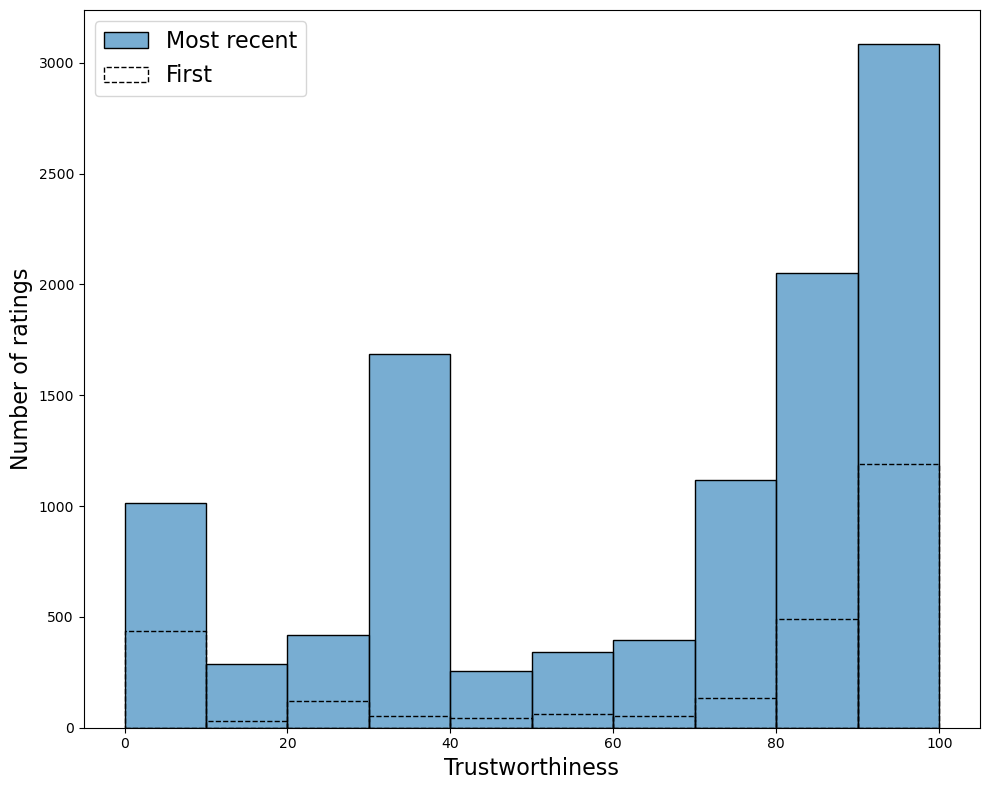

In [24]:
plt.figure(figsize=(10,8))
sns.histplot(data=df_recent, 
             x="Score", 
             bins=10, 
             alpha=0.6,
             edgecolor="black",
             label="Most recent")

sns.histplot(data=df_first,  
             x="Score",        
             bins=10,          
             edgecolor="black",  
             alpha=0.0,
             linestyle="dashed",
             label="First")

plt.xlabel("Trustworthiness", fontsize=16)
plt.ylabel("Number of ratings", fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig(join(figures_path,
                "f2a-trustworthiness_distribution.png"), 
                dpi=300)
plt.show()

In [25]:
df_15["file_year"] = pd.to_datetime(df_15.file_date)\
    .dt.to_period("Y")
df_15["file_month"] = pd.to_datetime(df_15.file_date)\
    .dt.to_period("M")

In [26]:
year_scores = df_15\
    .groupby("file_year")["Score"]\
    .agg(["mean", "std", "min", "max"])\
    .reset_index()
print(year_scores)

  file_year       mean        std  min    max
0      2019  71.767972  33.287474  0.0  100.0
1      2020  66.001125  34.087030  0.0  100.0
2      2021  63.692641  33.858325  0.0  100.0
3      2022  65.200969  33.158941  0.0  100.0
4      2023  64.532554  32.412332  0.0  100.0


In [27]:
month_scores = df_15\
    .groupby("file_month")["Score"]\
    .agg(["mean", "std", "min", "max"])\
    .reset_index()
#print first and last entry
print(month_scores.head(1))
print(month_scores.tail(1))

  file_month       mean        std  min    max
0    2019-03  70.786424  35.328616  0.0  100.0
   file_month       mean        std  min    max
56    2023-12  64.337728  32.294397  0.0  100.0


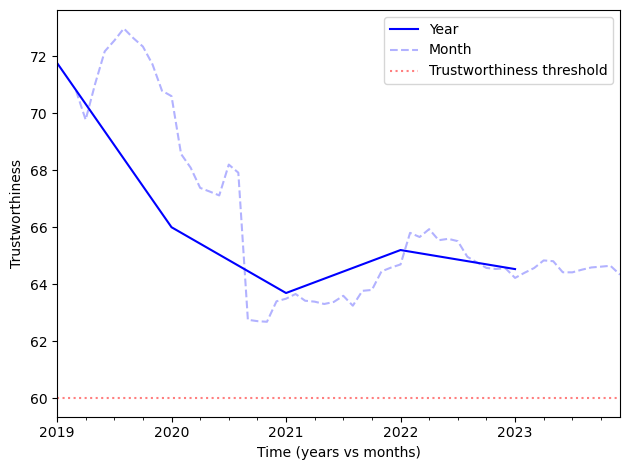

In [28]:
df_15.groupby(df_15.file_year).Score\
    .mean()\
    .plot(color="blue", label="Year")
df_15.groupby(df_15.file_month).Score\
    .mean()\
    .plot(color="blue", label="Month",
            alpha=0.3, linestyle="--")
plt.xlabel("Time (years vs months)")
plt.ylabel("Trustworthiness")
plt.axhline(y=60, 
            color= "red", 
            linestyle="dotted", 
            alpha=0.5, 
            label="Trustworthiness threshold")
plt.legend()
plt.tight_layout()
plt.savefig(join(figures_path,
                 "scores_over_time.png"), 
                 dpi=300)
plt.show()

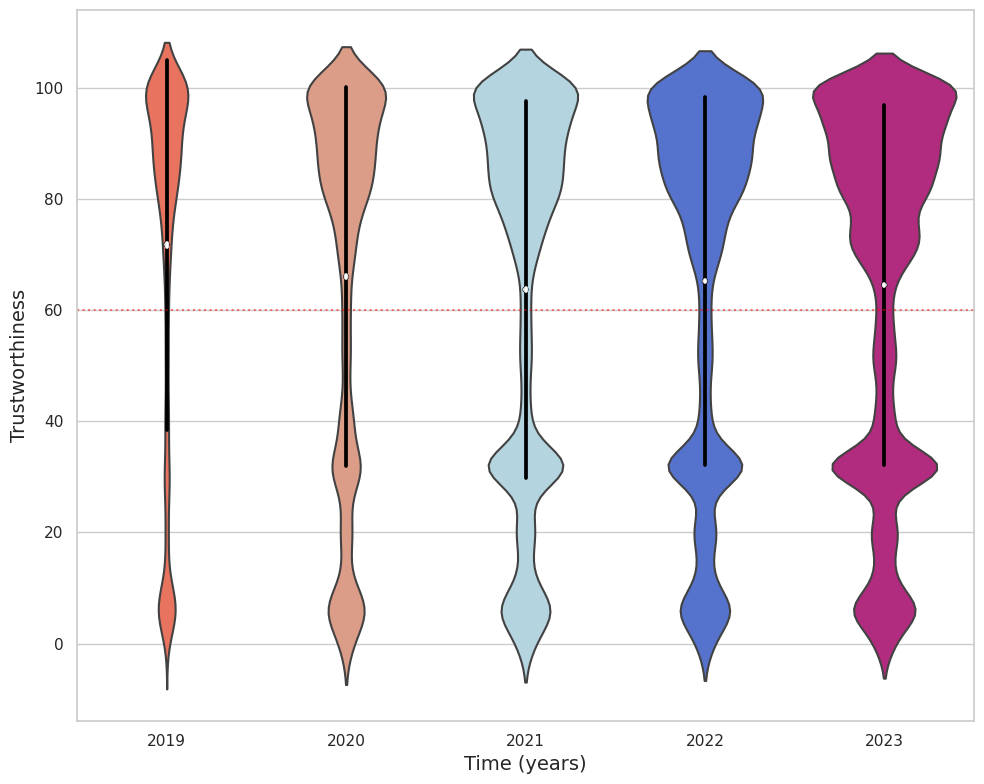

In [29]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 8))

#selected_ratings = ["T", "N"]
#df_selected_ratings = df_15[df_15["Rating"].isin(selected_ratings)]
year_colors = ["tomato", "darksalmon", "lightblue", "royalblue", "mediumvioletred"]

sns.violinplot(x="file_year", 
               y="Score",
               scale="count",
               data=df_15,
               inner=None,
               palette=year_colors)

sns.pointplot(
    data=df_15, 
    y="Score", 
    x="file_year", 
    estimator="mean",
    errorbar="sd",   
    color="black",
    scale=0.5,
    join=False) 

sns.pointplot(
    data=df_15, 
    y="Score", 
    x="file_year", 
    estimator="mean",
    color="white",  #white
    join=False,  
    markers="o",
    scale=0.4) 

plt.axhline(y=60, color="red", 
            linestyle="dotted",
            alpha=0.5, 
            label="Trustworthiness threshold")

plt.xlabel("Time (years)", fontsize=14)
plt.ylabel("Trustworthiness", fontsize=14)
plt.tight_layout()

plt.savefig(join(figures_path, 
                 "f2b-scores_over_time-violin.png"),
                 dpi=300)
plt.show()

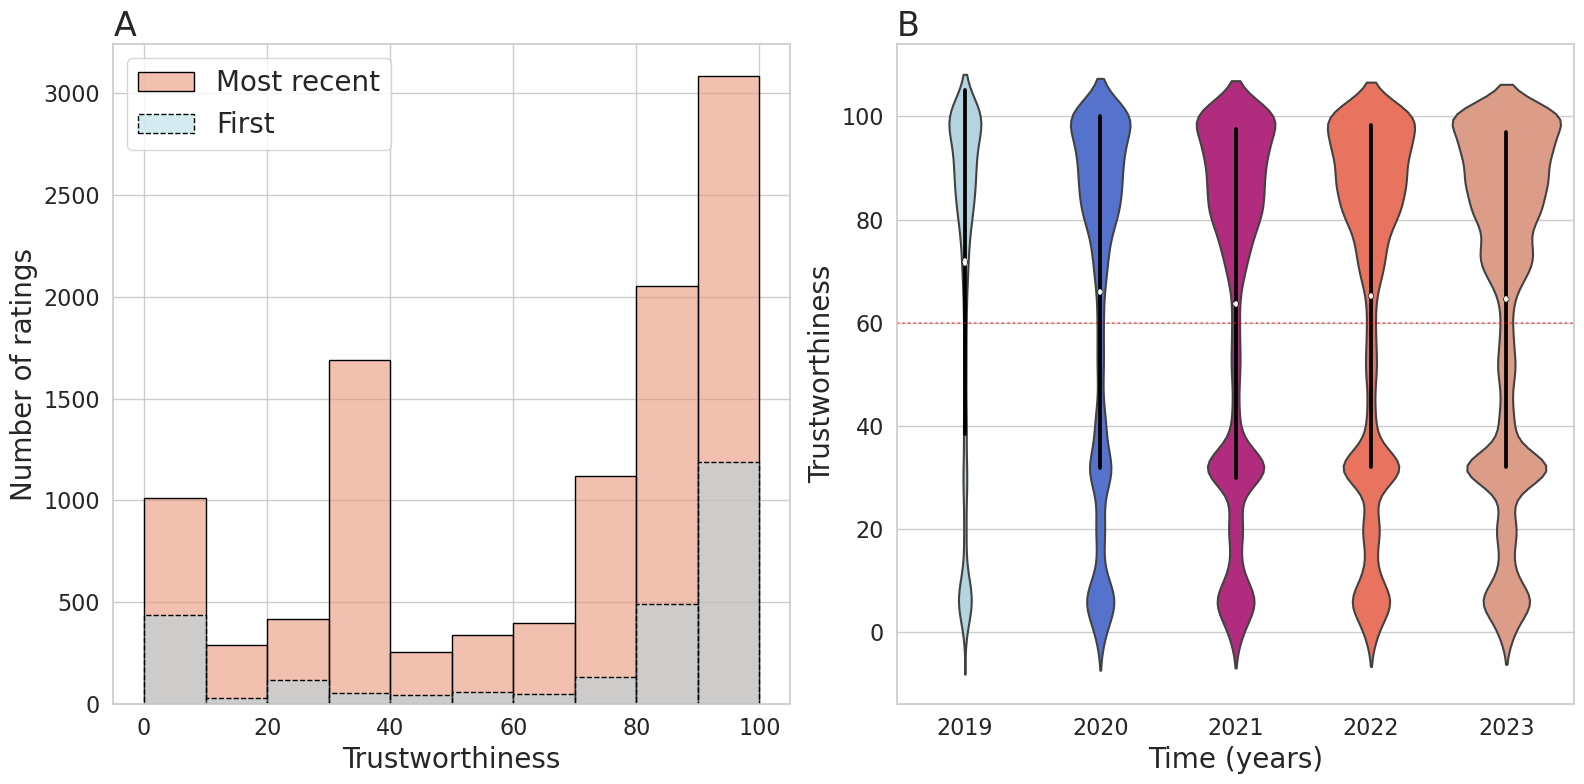

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
year_colors = ["lightblue", "royalblue",  "mediumvioletred", "tomato", "darksalmon"]

sns.histplot(data=df_recent, 
             x="Score", 
             bins=10, 
             alpha=0.6,
             edgecolor="black",
             color=year_colors[4],
             label="Most recent",
             ax=axs[0])

sns.histplot(data=df_first,  
             x="Score",        
             bins=10,          
             edgecolor="black",
             color=year_colors[0],
             alpha=0.5,
             linestyle="dashed",
             label="First",
             ax=axs[0])

axs[0].set_xlabel("Trustworthiness", fontsize=20)
axs[0].set_ylabel("Number of ratings", fontsize=20)
axs[0].legend(fontsize=20)
axs[0].set_title("A", fontsize=24, loc="left")
axs[0].tick_params(axis="x", labelsize=16)
axs[0].tick_params(axis="y", labelsize=16) 

sns.violinplot(x="file_year", 
               y="Score",
               scale="count",
               data=df_15,
               inner=None,
               palette=year_colors,
               ax=axs[1])

sns.pointplot(
    data=df_15, 
    y="Score", 
    x="file_year", 
    estimator="mean",
    errorbar="sd",   
    color="black",
    scale=0.5,
    join=False,
    ax=axs[1]) 

sns.pointplot(
    data=df_15, 
    y="Score", 
    x="file_year", 
    estimator="mean",
    color="white", 
    join=False,  
    markers="o",
    scale=0.4,
    ax=axs[1]) 

axs[1].axhline(y=60, color="red", 
               linestyle="dotted",
               alpha=0.5, 
               label="Trustworthiness threshold")

axs[1].set_xlabel("Time (years)", fontsize=20)
axs[1].set_ylabel("Trustworthiness", fontsize=20)
axs[1].set_title("B", fontsize=24, loc="left")
axs[1].tick_params(axis="x", labelsize=16)
axs[1].tick_params(axis="y", labelsize=16) 

plt.tight_layout()

plt.savefig(join(figures_path, "f2-panel.png"), dpi=300)
plt.show()

/home/jluehring/miniconda3/envs/twarcing/lib/python3.9/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


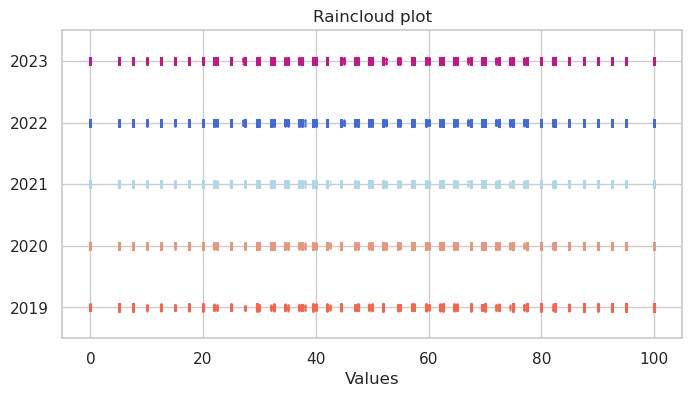

In [31]:
#from https://medium.com/mlearning-ai/getting-started-with-raincloud-plots-in-python-2ea5c2d01c11

grouped_data = [df_15[df_15["file_year"] == cat]["Score"]\
                .values for cat in df_15["file_year"]\
                .unique()]

fig, ax = plt.subplots(figsize=(8, 4))

# Boxplot data
boxplots_colors = ["yellowgreen", "olivedrab", "skyblue", "salmon", "thistle"]

bp = ax.boxplot(grouped_data, 
                patch_artist=True, 
                vert=False)

for patch, color in zip(bp["boxes"], boxplots_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.4)

# Scatterplot data
scatter_colors = ["tomato", "darksalmon", "lightblue", "royalblue", "mediumvioletred"]
for idx, features in enumerate(grouped_data):
    y = np.full(len(features), idx + 1)
    idxs = np.arange(len(y))
    out = y.astype(float)
    out.flat[idxs] += np.random.uniform(low=-.05, 
                                        high=.05, 
                                        size=len(idxs))
    y = out
    plt.scatter(features, y, 
                s=.3, 
                c=scatter_colors[idx])

# Violinplot data
violin_colors = ["yellowgreen", "olivedrab", "skyblue", "salmon", "thistle"]
for idx, features in enumerate(grouped_data):
    # Adjust y-coordinates to prevent overlap with box and scatter plots
    y = np.full(len(features), idx + 1.5)
    vp = ax.violinplot([features], 
                       positions=[idx + 1.5], 
                       points=500, 
                       showmeans=False, 
                       showextrema=False, 
                       showmedians=False, 
                       vert=False)
    
    for b in vp["bodies"]:
        b.set_color(violin_colors[idx])

plt.yticks(np.arange(1, len(grouped_data) + 1, 1), 
           df_15["file_year"].unique())  
plt.xlabel("Values")
plt.title("Raincloud plot")
plt.show()

### By added vs. removed sources

In [32]:
domain_changes_df = \
    domain_changes_df\
        .melt(id_vars="Date",
              value_vars=["Added", "Removed"],
              var_name="Change",
              value_name="Count")

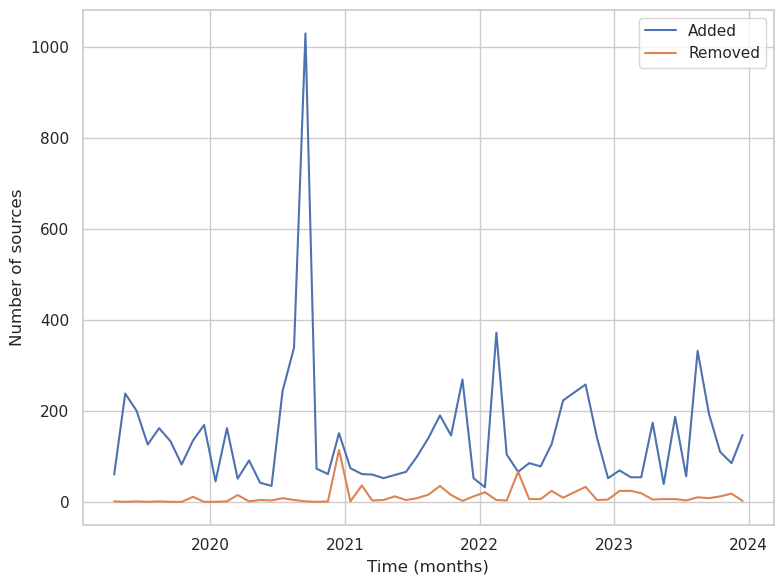

In [33]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=domain_changes_df,
             x="Date",
             y="Count",
             hue="Change")

plt.xlabel("Time (months)")
plt.ylabel("Number of sources") 
plt.legend()
plt.tight_layout()
plt.savefig(join(figures_path,
                 "n_sources_added_removed.png"), 
                 dpi=300)                 
plt.show()

In [34]:
added_means = []
removed_means = []
added_sds = []
removed_sds = []
months = []

for date in domain_changes.keys():
    added_sources = df_15[df_15.Domain.isin(domain_changes[date][0])]
    removed_sources = df_15[df_15.Domain.isin(domain_changes[date][1])]

    added_mean = added_sources["Score"].mean()
    removed_mean = removed_sources["Score"].mean()
    added_sd = added_sources["Score"].std()
    removed_sd = removed_sources["Score"].std()

    added_means.append(added_mean)
    removed_means.append(removed_mean)
    added_sds.append(added_sd)
    removed_sds.append(removed_sd)
    months.append(date)

added_df = pd.DataFrame({
    "Date": months,
    "Added_Mean": added_means,
    "Added_SD": added_sds})

removed_df = pd.DataFrame({
    "Date": months,
    "Removed_Mean": removed_means,
    "Removed_SD": removed_sds})

added_df["Change"] = "Added"
added_df = added_df\
            .rename(
                columns={
                    "Added_Mean": "Mean", 
                    "Added_SD": "SD"})

removed_df["Change"] = "Removed"
removed_df = removed_df\
            .rename(
                columns={
                    "Removed_Mean": "Mean", 
                    "Removed_SD": "SD"})

averages_df = pd.concat([added_df, removed_df])

domain_changes_df = \
    domain_changes_df\
        .merge(averages_df, 
               on=["Date", "Change"])

In [35]:
domain_changes_df[domain_changes_df["Change"] == "Added"]\
    .sort_values(by="Count", 
                 ascending=False)\
    .head(3)

,Date,Change,Count,Mean,SD
17,2020-09-15 01:00:00,Added,1030,35.274797,14.078383
34,2022-02-15 01:00:00,Added,372,88.108452,15.757896
16,2020-08-15 01:00:00,Added,339,60.797994,35.762535


In [36]:
print(f'Added sources: '
        f'Mean={round(added_df["Mean"].mean(), 2)}, '
        f'SD={round(added_df["SD"].mean(), 2)}')
print(f'Removed sources: '
        f'Mean={round(removed_df["Mean"].mean(), 2)}, '
        f'SD={round(removed_df["SD"].mean(), 2)}')

Added sources: Mean=61.59, SD=27.62
Removed sources: Mean=55.53, SD=19.08


### By country

In [37]:
country_count = df_15\
    .groupby("file_date")\
        .agg(
            Count=("Country", 
                   "nunique"),
            Score=("Score", 
                   "mean"),
            SD=("Score", 
                "std"),
            Countries=("Country", lambda x: ", ".join(sorted(x.unique())))
            )\
    .reset_index()

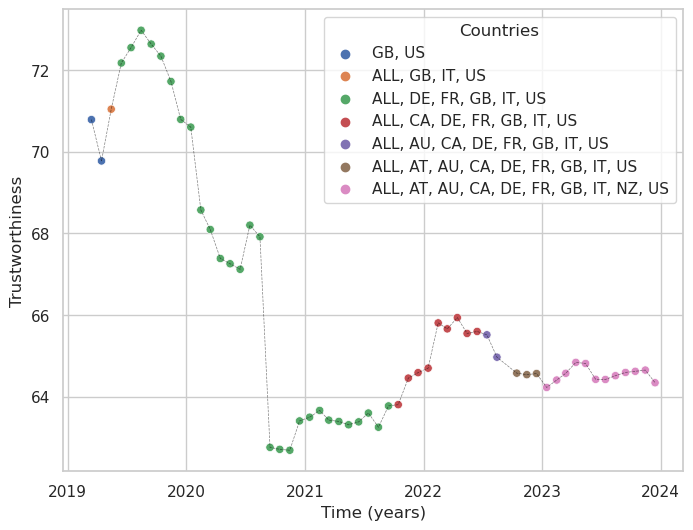

In [38]:
plt.figure(figsize=(8, 6))

sns.lineplot(data=country_count, 
    x="file_date", 
    y="Score", 
    color="black", 
    linestyle="--", 
    linewidth=0.5,
    alpha=0.5)

sns.scatterplot(data=country_count, 
                x="file_date", 
                y="Score", 
                hue="Countries")

plt.xlabel("Time (years)")
plt.ylabel("Trustworthiness")
plt.grid(True)
plt.legend(title="Countries")

plt.savefig(join(figures_path,
                    "fa1-scores_by_country.png"), 
                    dpi=300)
plt.show()

In [39]:
added_2020 = set(domain_changes[np.datetime64('2020-09-15T01:00:00.000000000')][0])
df_20_09 = df_15[df_15["file_month"] == "2020-09"]
added_sources = \
    df_20_09[df_20_09["Domain"]\
                  .isin(added_2020)]
added_sources["Country"]\
    .value_counts()

US     1015
ALL      15
IT        6
DE        5
FR        4
Name: Country, dtype: int64

### Updates

In [40]:
df_15["Last Updated"]=pd.to_datetime(df_15["Last Updated"],unit="ms")
df_15["Last Updated"].head(3)

0   2018-07-20 14:03:17.020
1   2018-07-20 14:03:21.115
2   2018-07-20 14:03:25.883
Name: Last Updated, dtype: datetime64[ns]

In [41]:
#inspect the duplicates
df_dups = \
    df_recent[df_recent\
              .duplicated(
                  subset="UUID",
                  keep=False)]

df_dups[["UUID", "Domain", 
            "Parent Domain", "Country", 
            "Language", "Score"]]\
            .sort_values(by="UUID")\
            .head(5)

,UUID,Domain,Parent Domain,Country,Language,Score
199,01e921ff-88c5-4a05-8dab-1721936480b8,alphanews.org,alphanews.org,US,en,49.5
200,01e921ff-88c5-4a05-8dab-1721936480b8,alphanewsmn.com,alphanews.org,US,en,49.5
3770,02519218-3cf4-4865-a3ac-d19eef2be450,dunning-kruger-times.com,dunning-kruger-times.com,US,en,20.0
3772,02519218-3cf4-4865-a3ac-d19eef2be450,bustatroll.org,dunning-kruger-times.com,US,en,20.0
3773,02519218-3cf4-4865-a3ac-d19eef2be450,conservativetears.com,dunning-kruger-times.com,US,en,20.0


In [42]:
df_dups[df_dups.duplicated(keep=False)] #only 4 are identical

,UUID,Domain,Parent Domain,Rating,Score,Last Updated,Country,Language,Does not repeatedly publish false content,Gathers and presents information responsibly,...,LINKEDIN,IOSAPP,ANDROIDAPP,OTHER,Contact Mail Form URL.1,Communities Served,BrandGuard Segments,False Narratives,Does not repeatedly publish false or egregiously misleading content,Has effective practices for correcting errors
7508,62f6815a-40f3-47f1-9570-6289e4a491e1,regenere.org,regenere.org,N,40.0,1677492428897,FR,fr,NaN,No,...,NaN,NaN,NaN,NaN,NaN,NaN,"Exclusion - Maximum Safety,Exclusion - High Sa...","0772ca0d-e66d-4c14-a32c-38663d1e84b3,d7563f08-...",No,No
7509,62f6815a-40f3-47f1-9570-6289e4a491e1,regenere.org,regenere.org,N,40.0,1677492428897,FR,fr,NaN,No,...,NaN,NaN,NaN,NaN,NaN,NaN,"Exclusion - Maximum Safety,Exclusion - High Sa...","0772ca0d-e66d-4c14-a32c-38663d1e84b3,d7563f08-...",No,No
7510,9df35e4e-5f29-427a-bcb5-58cdb181a879,regenere.org,regenere.org,N,40.0,1677492423177,ALL,en,NaN,No,...,NaN,NaN,NaN,NaN,https://www.rgnr.fr/contact.html,NaN,"Exclusion - Maximum Safety,Exclusion - High Sa...","0772ca0d-e66d-4c14-a32c-38663d1e84b3,d7563f08-...",No,No
7511,9df35e4e-5f29-427a-bcb5-58cdb181a879,regenere.org,regenere.org,N,40.0,1677492423177,ALL,en,NaN,No,...,NaN,NaN,NaN,NaN,https://www.rgnr.fr/contact.html,NaN,"Exclusion - Maximum Safety,Exclusion - High Sa...","0772ca0d-e66d-4c14-a32c-38663d1e84b3,d7563f08-...",No,No


In [43]:
df_15_UUID = \
    df_15.drop_duplicates(
        subset=["UUID", "Domain"], 
        keep="first")

print(f'Without UUID length = {len(df_15)}, '
      f'with UUID = {len(df_15_UUID)}.')

Without UUID length = 421870, with UUID = 51719.


In [44]:
def calculate_update_dff(df, variable):
    # group by domain and sort by last updated
    updates_sorted = \
        df\
        .groupby(variable)\
        .apply(lambda x: x.sort_values("Last Updated"))\
        .reset_index(drop=True)
    
    # calculate difference in last updated date per domain
    updates_diff = \
        updates_sorted\
            .groupby(variable)["Last Updated"]\
            .diff()
    
    # calculate mean difference per domain
    mean_diff_per_update = \
        updates_diff\
            .groupby(updates_sorted[variable])\
            .mean()
    
    return updates_sorted, mean_diff_per_update

domain_updates_sorted, mean_diff_per_domain = calculate_update_dff(df_15_UUID, "Domain")
print(mean_diff_per_domain)

Domain
1000logos.net                                  NaT
100fedup.com              228 days 17:32:42.892125
100giornidaleoni.it    121 days 23:40:35.276333334
100milefreepress.net      277 days 01:04:23.265500
100percentfedup.com    261 days 09:45:57.592285716
                                   ...            
zonazealots.com           210 days 02:33:29.196500
zt.20minut.ua                                  NaT
zuerst.de              140 days 00:42:35.585571428
zurzeit.at                  0 days 00:00:01.480000
zvw.de                    174 days 13:53:17.657400
Name: Last Updated, Length: 10521, dtype: timedelta64[ns]


In [45]:
mean_diff_per_domain.describe()

count                           9297
mean     243 days 21:43:37.352118744
std      126 days 09:47:00.893544786
min           0 days 00:00:00.098000
25%         162 days 06:10:32.870600
50%         210 days 02:33:29.356500
75%         355 days 17:05:52.792200
max        1109 days 19:36:32.340000
Name: Last Updated, dtype: object

In [46]:
print("Max:", mean_diff_per_domain[mean_diff_per_domain == mean_diff_per_domain.max()])
print("Min:", mean_diff_per_domain[mean_diff_per_domain == mean_diff_per_domain.min()])

Max: Domain
eblida.org   1109 days 19:36:32.340000
Name: Last Updated, dtype: timedelta64[ns]
Min: Domain
bbcnewsz.com   0 days 00:00:00.098000
Name: Last Updated, dtype: timedelta64[ns]


In [47]:
domain_updates_sorted["Score_diff"] = domain_updates_sorted\
                                        .groupby("Domain")["Score"]\
                                        .diff()
domain_score_diff = domain_updates_sorted\
                            .groupby("Domain")["Score_diff"]\
                            .mean()

print(f'The average score difference between updates is: '
      f'{domain_score_diff.mean()}, '
      f'SD = {domain_score_diff.std()}.')
print(f'The range of score differences is: '
      f'max = {domain_score_diff.max()}, '
      f'min={domain_score_diff.min()}.')

The average score difference between updates is: -0.16888892383376733, SD = 3.093745673679765.
The range of score differences is: max = 62.5, min=-35.5.


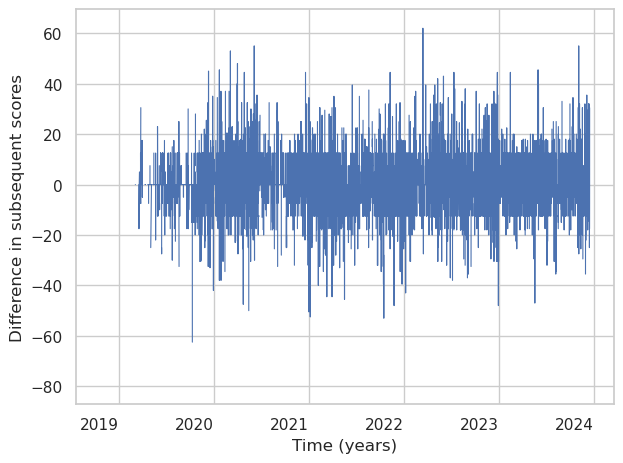

In [48]:
domain_updates_sorted\
    .groupby(domain_updates_sorted["Last Updated"]).Score_diff\
    .mean()\
    .plot(linewidth=0.8)

plt.figsize=(8, 6)
plt.ylabel("Difference in subsequent scores")
plt.xlabel("Time (years)")
plt.xticks(rotation=0)
plt.tight_layout()

plt.savefig(join(figures_path, "fa2-score_updates.png"), 
            dpi=300)
plt.show()

/tmp/ipykernel_1917152/3012301801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_15_UUID["last_updated_month"] = pd.to_datetime(df_15_UUID["Last Updated"])\


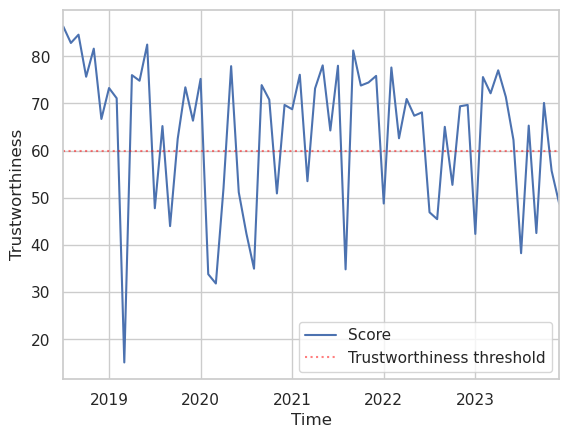

In [49]:
df_15_UUID["last_updated_month"] = pd.to_datetime(df_15_UUID["Last Updated"])\
                                .dt.to_period("M")
df_15_UUID.groupby(df_15_UUID.last_updated_month).Score\
    .mean()\
    .plot(label="Score")
plt.xlabel("Time")
plt.ylabel("Trustworthiness")
plt.axhline(y=60, color="red", 
            linestyle="dotted", 
            alpha=0.5, 
            label="Trustworthiness threshold")
plt.savefig(join(figures_path, "average_score_per_update.png"), dpi=300)
plt.legend()
plt.show()

In [50]:
domain_updates_sorted\
        .sort_values(
            "Score_diff", ascending=True)\
                [["Domain", "Score_diff", "Last Updated"]]\
        .head(5)

,Domain,Score_diff,Last Updated
8174,conservativedailynews.com,-80.0,2020-11-23 21:39:32.187
43738,thefederalist.com,-62.5,2019-10-10 17:21:38.137
44448,theragingpatriot.com,-53.0,2021-10-15 12:19:44.207
44314,theohiostar.com,-52.5,2021-01-05 22:53:34.221
34229,pluralist.com,-50.5,2020-12-31 18:12:44.411


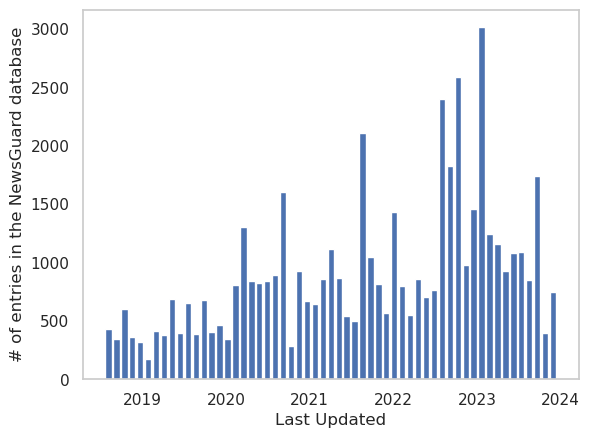

In [51]:
df_15_UUID["Last Updated"].hist(bins=df_15_UUID["file_date"].nunique(), 
                               #color="blue", 
                               rwidth=0.8,
                               grid=False)
plt.xlabel("Last Updated")
plt.ylabel("# of entries in the NewsGuard database")
#plt.savefig(join(figures_path, "last_updated_distribution.png"), dpi=300)
plt.show()

In [52]:
#how many times do parent domains get updates?
parent_updates_sorted, mean_diff_per_parent = \
    calculate_update_dff(df_15_UUID, "Parent Domain")
mean_diff_per_parent.describe()

count                           466
mean     59 days 12:00:33.085290466
std      60 days 09:18:21.655888439
min                 0 days 00:00:00
25%       3 days 18:03:01.247381838
50%      46 days 03:36:14.167923611
75%      93 days 09:32:08.639604167
max        364 days 00:36:04.544000
Name: Last Updated, dtype: object

In [53]:
parent_updates_sorted["Score_diff"] = \
    parent_updates_sorted\
        .groupby("Parent Domain")["Score"]\
        .diff()

parent_updates_sorted\
        .sort_values(
            "Score_diff", ascending=True)\
                [["Parent Domain", "Score_diff", "Last Updated"]]\
        .head(3)

,Parent Domain,Score_diff,Last Updated
23576,redstateobserver.com,-47.0,2023-05-18 22:04:09.100
24041,sarahpalin.com,-45.5,2021-05-17 12:00:50.607
25865,thefreethoughtproject.com,-42.0,2019-12-30 18:42:01.869


In [54]:
parent_score_diff = parent_updates_sorted\
                            .groupby("Parent Domain")["Score_diff"]\
                            .mean()

print(f'The average score difference between updates is: '
      f'{parent_score_diff.mean()}, '
      f'SD = {parent_score_diff.std()}.')
print(f'The range of score differences is: '
      f'max = {parent_score_diff.max()}, '
      f'min={parent_score_diff.min()}.')

The average score difference between updates is: 0.1398053074707947, SD = 1.942189706521089.
The range of score differences is: max = 27.5, min=-11.75.


## Composition of trustworthiness score

In [55]:
criteria_columns_all = df_15[
       ["Does not repeatedly publish false content",
       "Gathers and presents information responsibly",
       "Regularly corrects or clarifies errors",
       "Handles the difference between news and opinion responsibly",
       "Avoids deceptive headlines",
       "Website discloses ownership and financing",
       "Clearly labels advertising",
       "Reveals who's in charge, including any possible conflicts of interest",
       "The site provides names of content creators, along with either contact or biographical information",
       "Does not repeatedly publish false or egregiously misleading content",
       "Has effective practices for correcting errors"]
       ]

In [56]:
counts_data = []

for column in criteria_columns_all:
    column_counts = df_15\
                        .groupby("file_date")[column]\
                        .count()\
                        .reset_index()
    column_counts = column_counts\
                        .rename(columns={column: "count"})
    column_counts["criteria"] = column
    counts_data.append(column_counts)

counts_table = pd.concat(counts_data, ignore_index=True)

counts_table = counts_table[["file_date", "criteria", "count"]]

In [57]:
first_ratings = counts_table[counts_table["count"] > 0]


first_ratings = first_ratings\
    .groupby("criteria")\
        .agg(
            min_date=("file_date", "min"),
            max_date=("file_date", "max"))\
    .reset_index()

first_ratings

,criteria,min_date,max_date
0,Avoids deceptive headlines,2019-03-15 01:00:00,2023-12-15 01:00:00
1,Clearly labels advertising,2019-03-15 01:00:00,2023-12-15 01:00:00
2,Does not repeatedly publish false content,2019-03-15 01:00:00,2023-11-15 01:00:00
3,Does not repeatedly publish false or egregious...,2023-12-15 01:00:00,2023-12-15 01:00:00
4,Gathers and presents information responsibly,2019-03-15 01:00:00,2023-12-15 01:00:00
5,Handles the difference between news and opinio...,2019-03-15 01:00:00,2023-12-15 01:00:00
6,Has effective practices for correcting errors,2023-12-15 01:00:00,2023-12-15 01:00:00
7,Regularly corrects or clarifies errors,2019-03-15 01:00:00,2023-11-15 01:00:00
8,"Reveals who's in charge, including any possibl...",2019-03-15 01:00:00,2023-12-15 01:00:00
9,"The site provides names of content creators, a...",2019-03-15 01:00:00,2023-12-15 01:00:00


In [58]:
criteria_columns_recent = df_recent[
       ["Does not repeatedly publish false or egregiously misleading content",
       "Gathers and presents information responsibly",
       "Handles the difference between news and opinion responsibly",
       "Avoids deceptive headlines",
       "Website discloses ownership and financing",
       "Clearly labels advertising",
       "Reveals who's in charge, including any possible conflicts of interest",
       "The site provides names of content creators, along with either contact or biographical information",
       "Has effective practices for correcting errors"]
       ]

In [59]:
for df in [df_15, df_15_UUID, df_recent, criteria_columns_recent, criteria_columns_all]:
    df = df.rename(columns={
    "Reveals who's in charge, including any possible conflicts of interest": 
    "Reveals who's in charge,\n including any possible conflicts of interest", 
    "The site provides names of content creators, along with either contact or biographical information":
    "The site provides names of content creators,\n along with either contact or biographical information"}, 
    inplace=True)

/tmp/ipykernel_1917152/3335134207.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df = df.rename(columns={
/tmp/ipykernel_1917152/3335134207.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df = df.rename(columns={
/tmp/ipykernel_1917152/3335134207.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df = df.rename(columns={
/tmp/ipykernel_1917152/3335134207.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

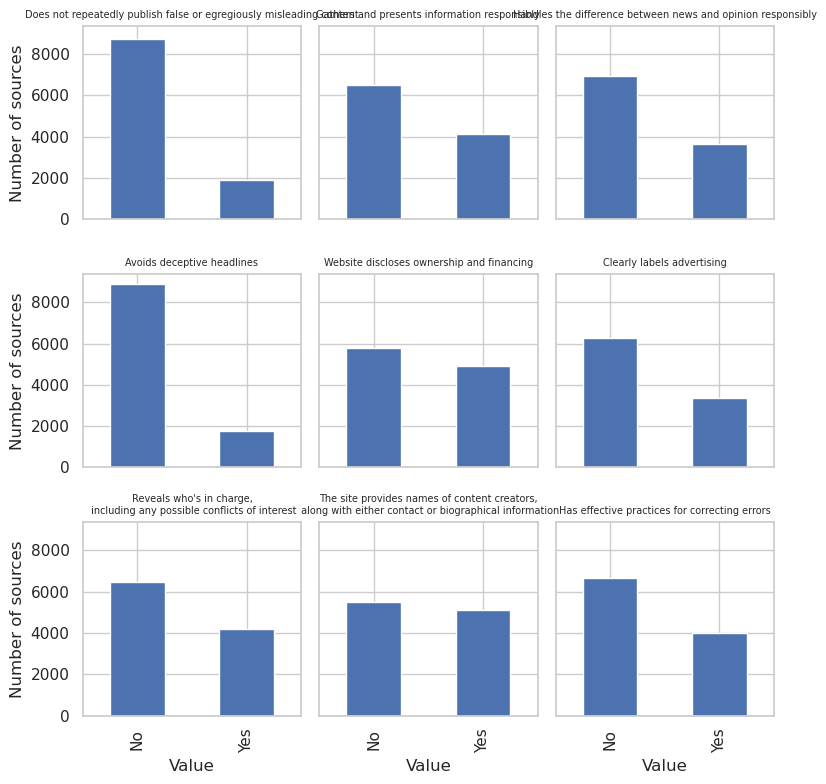

In [60]:
def plot_yesno(columns):
    fig, axs = plt.subplots(nrows=3, 
                            ncols=3, 
                            sharex=True,
                            sharey=True,
                            figsize=(8, 8))

    for i, col in enumerate(columns):
        row = i // 3 
        col_in_row = i % 3  
        df_recent[col]\
            .value_counts()\
            .plot(kind="bar",
                  ax=axs[row, col_in_row])
        axs[row, col_in_row].set_xlabel("Value")
        axs[row, col_in_row].set_ylabel("Number of sources")
        axs[row, col_in_row].set_title(f'{col}', fontsize=7)

    plt.tight_layout()
    plt.show()

plot_yesno(criteria_columns_recent)

In [61]:
df_recent_critera = pd.melt(criteria_columns_recent, 
                      value_vars=criteria_columns_recent, 
                      var_name="Criteria", 
                      value_name="Label")
criteria_counts = df_recent_critera\
                    .groupby(["Criteria", "Label"])\
                    .size()\
                    .unstack(fill_value=0)\
                    .reset_index()

criteria_counts["Total"] = criteria_counts["Yes"] + criteria_counts["No"]
criteria_counts["Yes%"] = criteria_counts["Yes"] / criteria_counts["Total"] * 100
criteria_counts["No%"] = criteria_counts["No"] / criteria_counts["Total"] * 100

criteria_counts.sort_values(by="Yes", ascending=False)

Label,Criteria,No,Yes,Total,Yes%,No%
0,Avoids deceptive headlines,1742,8903,10645,83.635510,16.364490
2,Does not repeatedly publish false or egregious...,1922,8736,10658,81.966598,18.033402
4,Handles the difference between news and opinio...,3628,6967,10595,65.757433,34.242567
3,Gathers and presents information responsibly,4149,6509,10658,61.071496,38.928504
6,"Reveals who's in charge,\n including any possi...",4190,6465,10655,60.675739,39.324261
1,Clearly labels advertising,3363,6253,9616,65.027038,34.972962
7,"The site provides names of content creators,\n...",5508,5114,10622,48.145359,51.854641
8,Website discloses ownership and financing,5767,4891,10658,45.890411,54.109589
5,Has effective practices for correcting errors,6671,3986,10657,37.402646,62.597354


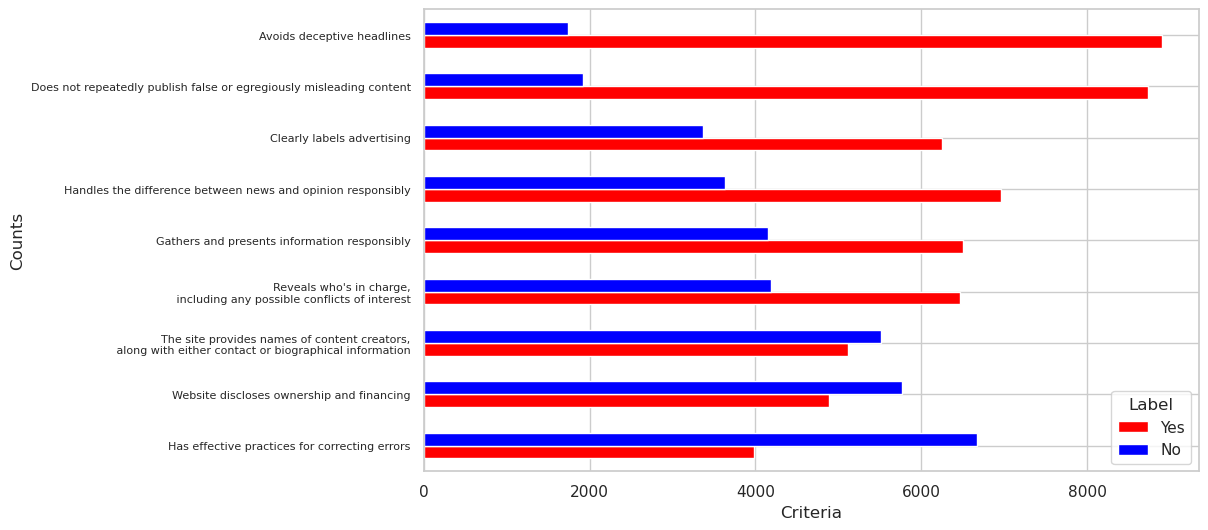

In [62]:
criteria_counts\
    .sort_values("No", ascending=False)\
    .plot(x="Criteria", 
          y=["Yes", "No"],
          kind="barh", 
          stacked=False,
          color=["red", "blue"], 
          figsize=(10, 6))
plt.xlabel("Criteria")
plt.ylabel("Counts")
plt.yticks(fontsize=8)
plt.legend(title="Label", 
           loc="lower right")

plt.savefig(join(figures_path, "criteria_counts.png"),
            dpi=300)
plt.show()

In [63]:
criteria_columns_recent = \
    criteria_columns_recent\
        .replace({"Yes": 1, "No": 0})\
        .fillna(0)

cooccurrence = \
    criteria_columns_recent\
        .T\
        .dot(criteria_columns_recent)
cooccurrence

,Does not repeatedly publish false or egregiously misleading content,Gathers and presents information responsibly,Handles the difference between news and opinion responsibly,Avoids deceptive headlines,Website discloses ownership and financing,Clearly labels advertising,"Reveals who's in charge,\n including any possible conflicts of interest","The site provides names of content creators,\n along with either contact or biographical information",Has effective practices for correcting errors
Does not repeatedly publish false or egregiously misleading content,8736.0,6509.0,6504.0,8574.0,4634.0,5552.0,5539.0,4780.0,3984.0
Gathers and presents information responsibly,6509.0,6509.0,6033.0,6496.0,4365.0,4908.0,5188.0,4454.0,3797.0
Handles the difference between news and opinion responsibly,6504.0,6033.0,6967.0,6651.0,4365.0,5151.0,5195.0,4473.0,3661.0
Avoids deceptive headlines,8574.0,6496.0,6651.0,8903.0,4651.0,5634.0,5645.0,4884.0,3970.0
Website discloses ownership and financing,4634.0,4365.0,4365.0,4651.0,4891.0,3842.0,4034.0,3272.0,2883.0
Clearly labels advertising,5552.0,4908.0,5151.0,5634.0,3842.0,6253.0,4350.0,3815.0,3363.0
"Reveals who's in charge,\n including any possible conflicts of interest",5539.0,5188.0,5195.0,5645.0,4034.0,4350.0,6465.0,4202.0,3123.0
"The site provides names of content creators,\n along with either contact or biographical information",4780.0,4454.0,4473.0,4884.0,3272.0,3815.0,4202.0,5114.0,3168.0
Has effective practices for correcting errors,3984.0,3797.0,3661.0,3970.0,2883.0,3363.0,3123.0,3168.0,3986.0


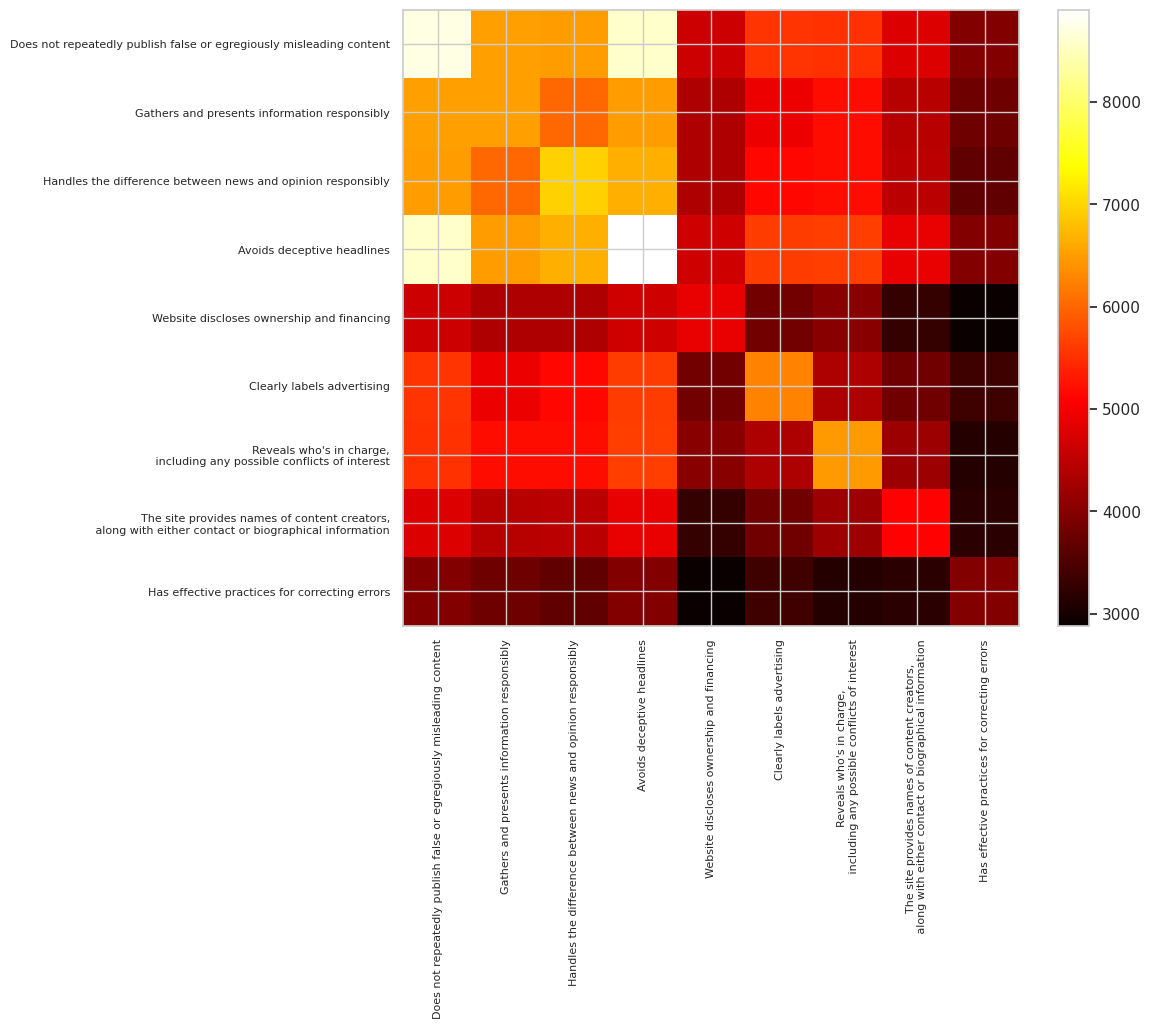

In [64]:
plt.figure(figsize=(10, 8))
plt.imshow(cooccurrence, 
           cmap="hot", 
           interpolation="nearest")

plt.xticks(range(len(cooccurrence)), 
           cooccurrence.columns, 
           rotation=90, 
           fontsize=8)
plt.yticks(range(len(cooccurrence)), 
           cooccurrence.index, 
           fontsize=8)
plt.colorbar()
#for i in range(len(cooccurrence)):
#    for j in range(len(cooccurrence)):
#        plt.text(j, i, cooccurrence.iloc[i, j], 
#        ha="center", va="center", color="grey")
plt.show()

In [65]:
#correlation matrix
corr = criteria_columns_recent.corr()
corr.style.background_gradient(cmap="coolwarm")

,Does not repeatedly publish false or egregiously misleading content,Gathers and presents information responsibly,Handles the difference between news and opinion responsibly,Avoids deceptive headlines,Website discloses ownership and financing,Clearly labels advertising,"Reveals who's in charge, including any possible conflicts of interest","The site provides names of content creators, along with either contact or biographical information",Has effective practices for correcting errors
Does not repeatedly publish false or egregiously misleading content,1.000000,0.632260,0.487145,0.874594,0.364724,0.306745,0.232961,0.351954,0.399764
Gathers and presents information responsibly,0.632260,1.000000,0.744368,0.600000,0.559896,0.471331,0.530666,0.543196,0.562926
Handles the difference between news and opinion responsibly,0.487145,0.744368,1.000000,0.518585,0.496352,0.475274,0.445746,0.483357,0.458941
Avoids deceptive headlines,0.874594,0.600000,0.518585,1.000000,0.349543,0.309731,0.243236,0.372876,0.376572
Website discloses ownership and financing,0.364724,0.559896,0.496352,0.349543,1.000000,0.408651,0.446767,0.380439,0.433207
Clearly labels advertising,0.306745,0.471331,0.475274,0.309731,0.408651,1.000000,0.279080,0.353102,0.431678
"Reveals who's in charge, including any possible conflicts of interest",0.232961,0.530666,0.445746,0.243236,0.446767,0.279080,1.000000,0.459266,0.316063
"The site provides names of content creators, along with either contact or biographical information",0.351954,0.543196,0.483357,0.372876,0.380439,0.353102,0.459266,1.000000,0.507955
Has effective practices for correcting errors,0.399764,0.562926,0.458941,0.376572,0.433207,0.431678,0.316063,0.507955,1.000000


In [66]:
#save as latex table
corr.to_latex(join(tables_path, "criteria_correlation_recent.tex"))

/tmp/ipykernel_1917152/1938248488.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  corr.to_latex(join(tables_path, "criteria_correlation_recent.tex"))


In [67]:
#exploratory factor analysis of criteria
chi_square_value,p_value=calculate_bartlett_sphericity(criteria_columns_recent)
chi_square_value, p_value # there is a significant correlation among the variables

(55729.47940051169, 0.0)

In [68]:
#squared partial correlations
kmo_all,kmo_model=calculate_kmo(criteria_columns_recent)
kmo_model #adequate sample size (larger than 0.5)

/home/jluehring/miniconda3/envs/twarcing/lib/python3.9/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.8480992407892035

In [69]:
fa = FactorAnalyzer(rotation=None)
fa.fit(criteria_columns_recent, 25)
ev, v = fa.get_eigenvalues()
ev #2 factors have eigenvalues > 1

array([4.66026921, 1.15357739, 0.76005167, 0.66882936, 0.55043085,
       0.44999158, 0.4213669 , 0.22013828, 0.11534476])

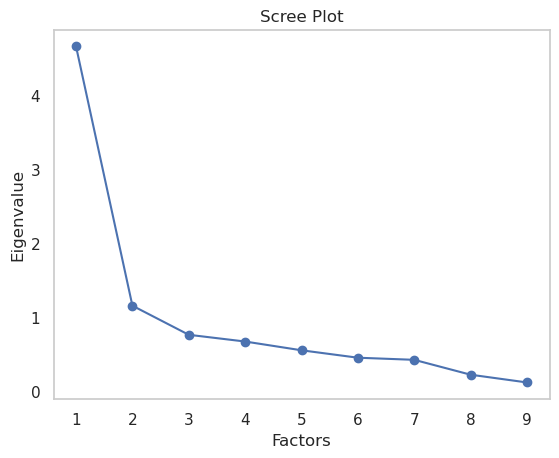

In [70]:
#screeplot
plt.scatter(range(1,criteria_columns_recent.shape[1]+1),ev)
plt.plot(range(1,criteria_columns_recent.shape[1]+1),ev)
plt.title("Scree Plot")
plt.xlabel("Factors")
plt.ylabel("Eigenvalue")
plt.grid()
plt.show()

In [71]:
fa = FactorAnalyzer(n_factors=2, 
                    rotation="oblimin")
fa.fit(criteria_columns_recent)
loadings = fa.loadings_
loadings_df = pd.DataFrame(loadings, 
                           index=criteria_columns_recent.columns)
loadings_df

,0,1
Does not repeatedly publish false or egregiously misleading content,-0.007203,0.971009
Gathers and presents information responsibly,0.764231,0.190377
Handles the difference between news and opinion responsibly,0.712764,0.103768
Avoids deceptive headlines,0.051275,0.872558
Website discloses ownership and financing,0.685767,-0.045996
Clearly labels advertising,0.585557,-0.024349
"Reveals who's in charge,\n including any possible conflicts of interest",0.711580,-0.184192
"The site provides names of content creators,\n along with either contact or biographical information",0.685368,-0.043339
Has effective practices for correcting errors,0.635677,0.024669


In [72]:
#variance explained
fa.get_factor_variance()[0]

array([3.28807742, 1.79034981])

In [73]:
#in percentage
fa.get_factor_variance()[2]*100

array([36.5341936 , 56.42696932])

### Trustworthiness

In [74]:
#regression: which criteria are most important for the overall score?
for criteria in criteria_columns_recent.columns:
    df_recent = df_recent.replace({criteria: {"Yes": 1, "No": 0}})
    df_recent = df_recent.dropna(subset=[criteria])
    df_recent = df_recent.dropna(subset=["Score"])
    X = df_recent[criteria]
    y = df_recent["Score"]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    print(f'Criteria: {criteria}')
    print(f'Coefficient: {model.params[criteria]}')
    print(f'P-value: {model.pvalues[criteria]}')

Criteria: Does not repeatedly publish false or egregiously misleading content
Coefficient: 61.93807002159397
P-value: 0.0
Criteria: Gathers and presents information responsibly
Coefficient: 59.684019338631884
P-value: 0.0
Criteria: Handles the difference between news and opinion responsibly
Coefficient: 53.22896371285186
P-value: 0.0
Criteria: Avoids deceptive headlines
Coefficient: 61.914984198684394
P-value: 0.0
Criteria: Website discloses ownership and financing
Coefficient: 41.178929750075
P-value: 0.0
Criteria: Clearly labels advertising
Coefficient: 36.84793542678428
P-value: 0.0
Criteria: Reveals who's in charge,
 including any possible conflicts of interest
Coefficient: 31.527043420954744
P-value: 0.0
Criteria: The site provides names of content creators,
 along with either contact or biographical information
Coefficient: 40.235255413565525
P-value: 0.0
Criteria: Has effective practices for correcting errors
Coefficient: 45.45482084895889
P-value: 0.0


In [75]:
#multiple combinations of criteria
combinations = criteria_columns_recent\
                .groupby(criteria_columns_recent.columns\
                         .tolist())\
                .size()\
                .reset_index(name="Counts")

combinations["Percentage"] = \
    combinations["Counts"]/(df_recent["Score"].count())*100

combinations\
    .sort_values("Counts", ascending=False)\
    .head(10)

,Does not repeatedly publish false or egregiously misleading content,Gathers and presents information responsibly,Handles the difference between news and opinion responsibly,Avoids deceptive headlines,Website discloses ownership and financing,Clearly labels advertising,"Reveals who's in charge,\n including any possible conflicts of interest","The site provides names of content creators,\n along with either contact or biographical information",Has effective practices for correcting errors,Counts,Percentage
204,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1500,15.693660
73,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1290,13.496547
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,974,10.190416
203,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,505,5.283532
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,503,5.262607
188,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,476,4.980121
201,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,419,4.383762
179,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,387,4.048964
202,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,345,3.609542
200,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,333,3.483992


In [76]:
#criteria changes over time 
df_15 = df_15\
        .replace({"Yes": 1, 
                  "No": 0})

criteria_avg = df_15\
    .groupby("file_month")[criteria_columns_all.columns]\
    .mean()

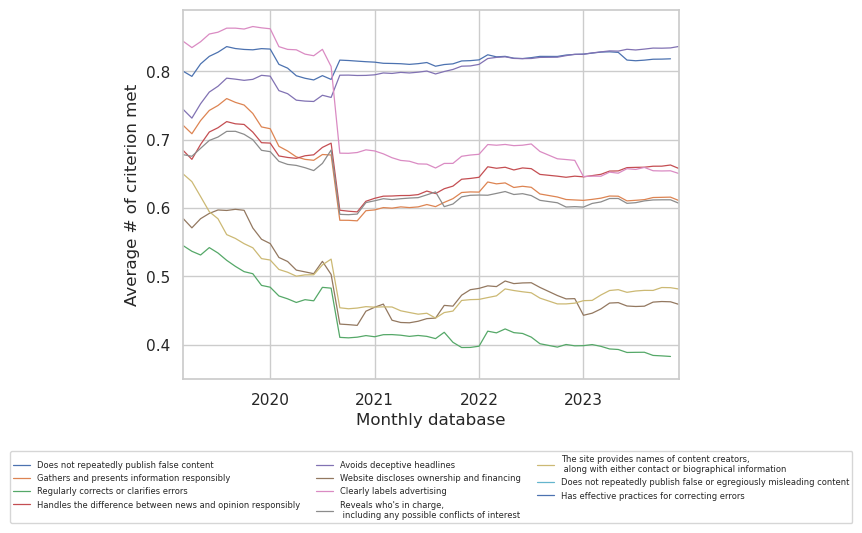

In [77]:
for col in criteria_columns_all:
    criteria_avg[col]\
        .plot(label=col, linewidth=0.9)
    
plt.xlabel("Monthly database")
plt.ylabel("Average # of criterion met")
plt.legend(loc="lower center", 
           bbox_to_anchor=(0.5, -0.4), 
           ncol=3, 
           fontsize=6)
plt.show()

### Updates

In [78]:
df_15_UUID = \
    df_15_UUID\
        .replace({"Yes": 1, 
                  "No": 0})

In [79]:
#collapse the two columns
df_15_UUID["Does not repeatedly publish false or egregiously misleading content"] = \
    df_15_UUID[["Does not repeatedly publish false content", 
                "Does not repeatedly publish false or egregiously misleading content"]]\
    .max(axis=1)

df_15_UUID["Has effective practices for correcting errors"] = \
    df_15_UUID[["Regularly corrects or clarifies errors", 
                "Has effective practices for correcting errors"]]\
    .max(axis=1)

In [80]:
#changes over time per criterion per domain
criteria_dated = df_15_UUID\
                    .groupby("Domain")\
                    .apply(lambda x: x \
                        .sort_values("Last Updated"))\
                    .reset_index(drop=True)

criteria_dated.head(3)

,UUID,Domain,Parent Domain,Rating,Score,Last Updated,Country,Language,Does not repeatedly publish false content,Gathers and presents information responsibly,...,OTHER,Contact Mail Form URL.1,Communities Served,BrandGuard Segments,False Narratives,Does not repeatedly publish false or egregiously misleading content,Has effective practices for correcting errors,file_year,file_month,last_updated_month
0,b9704871-32df-4721-881c-2dc6d03d8905,1000logos.net,NaN,FL,NaN,2023-09-27 04:25:20.721,US,en,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,2023-10,2023-09
1,07be0795-9c5e-43ad-932b-e7e0154d5828,100fedup.com,100percentfedup.com,N,7.5,2018-09-08 22:26:33.205,US,en,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2019,2019-03,2018-09
2,a7cfbf89-68cf-4a16-9b92-96cbda6cdad5,100fedup.com,100percentfedup.com,N,7.5,2019-10-04 23:22:52.632,US,en,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2019,2019-10,2019-10


In [81]:
criteria_diffs = pd.DataFrame()
for criterion in criteria_columns_recent.columns:
    criteria_dated[criterion] = \
        criteria_dated[criterion]\
            .replace({"Yes": 1, "No": 0})
    criteria_dated[f'Diff_{criterion}'] = \
        criteria_dated\
            .groupby("Domain")[criterion]\
            .diff()
    criteria_diffs[f'Diff_{criterion}'] = \
        criteria_dated[f'Diff_{criterion}']
criteria_diffs.tail(10)

,Diff_Does not repeatedly publish false or egregiously misleading content,Diff_Gathers and presents information responsibly,Diff_Handles the difference between news and opinion responsibly,Diff_Avoids deceptive headlines,Diff_Website discloses ownership and financing,Diff_Clearly labels advertising,"Diff_Reveals who's in charge,\n including any possible conflicts of interest","Diff_The site provides names of content creators,\n along with either contact or biographical information",Diff_Has effective practices for correcting errors
51709,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
51710,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
51711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
criteria_change = \
    criteria_diffs\
        .mean()\
        .reset_index()\
        .rename(columns={"index": "Criteria", 
                         0: "Avg Change"})

total_change = criteria_diffs\
                    .astype(bool)\
                    .sum()

negative_changes = (criteria_diffs < 0).sum()
positive_changes = (criteria_diffs > 0).sum()

negative_changes_percentage = \
    (negative_changes / criteria_dated.Domain.nunique() * 100)\
    .round(2)


positive_changes_percentage = \
    (positive_changes / criteria_dated.Domain.nunique() * 100)\
    .round(2)

criteria_changes = pd.DataFrame({
    "Criteria": criteria_change["Criteria"],
    "Total Change": total_change.values,
    "Avg. Change": criteria_change["Avg Change"],
    "Negative Changes": -negative_changes_percentage.values,
    "Positive Changes": positive_changes_percentage.values}
    )

criteria_changes["Criteria"] = \
    criteria_changes["Criteria"]\
        .str.replace("Diff_", "")

criteria_changes.sort_values(by="Total Change")

,Criteria,Total Change,Avg. Change,Negative Changes,Positive Changes
0,Does not repeatedly publish false or egregious...,11122,0.000613,-0.81,1.05
3,Avoids deceptive headlines,11237,0.002527,-0.86,1.83
1,Gathers and presents information responsibly,11243,-0.001079,-1.71,1.29
2,Handles the difference between news and opinio...,11694,0.004212,-1.90,3.53
6,"Reveals who's in charge,\n including any possi...",12055,-0.001422,-5.63,5.08
7,"The site provides names of content creators,\n...",12349,0.004421,-5.55,7.26
8,Has effective practices for correcting errors,12636,0.002305,-7.66,8.55
4,Website discloses ownership and financing,13166,-0.005786,-11.74,9.50
5,Clearly labels advertising,15279,-0.015558,-9.23,3.64


In [83]:
criteria_dated\
    [criteria_dated["Diff_Website discloses ownership and financing"] == -1]\
    ["Domain"].unique()

array(['1011now.com', '12thmanrising.com', '13abc.com', ...,
       'yournewswire.com', 'zeit.de', 'zonazealots.com'], dtype=object)

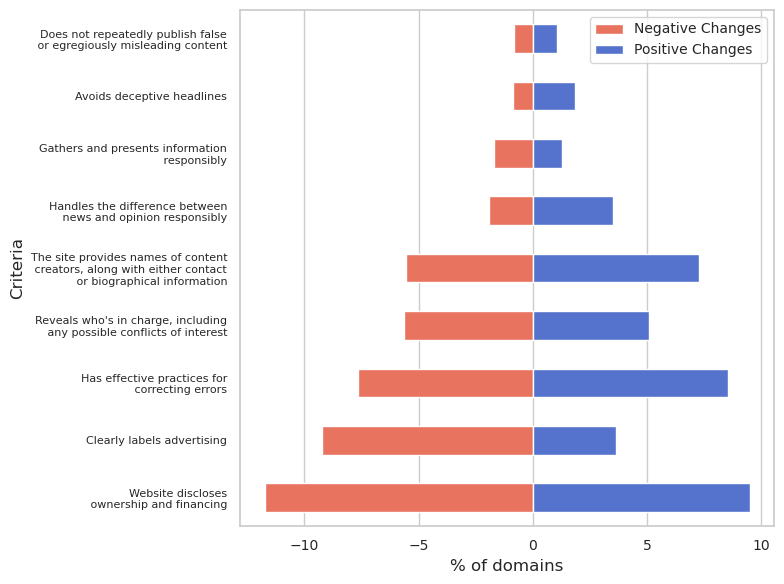

In [84]:
#bar chart with change percentages
#change the label of one of the criteria
criteria_changes["Criteria"] = \
    criteria_changes["Criteria"]\
        .replace({"Does not repeatedly publish false or egregiously misleading content": 
                   "Does not repeatedly publish false\n or egregiously misleading content",
                   "Handles the difference between news and opinion responsibly":
                   "Handles the difference between\n news and opinion responsibly",
                   "The site provides names of content creators,\n along with either contact or biographical information":
                   "The site provides names of content\n creators, along with either contact\n or biographical information",
                   "Gathers and presents information responsibly":
                    "Gathers and presents information\n responsibly",
                    "Reveals who's in charge,\n including any possible conflicts of interest":
                    "Reveals who's in charge, including\n any possible conflicts of interest",
                    "Has effective practices for correcting errors":
                    "Has effective practices for\n correcting errors",
                    "Website discloses ownership and financing":
                    "Website discloses\n ownership and financing",
                   })

criteria_changes =\
    criteria_changes.sort_values(
        by="Negative Changes", 
        ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=criteria_changes, 
            x="Negative Changes", 
            y="Criteria", 
            color=year_colors[3], 
            label="Negative Changes",
            width=0.5)
sns.barplot(data=criteria_changes, 
            x="Positive Changes", 
            y="Criteria", 
            color=year_colors[1], 
            width=0.5,
            label="Positive Changes")

plt.xlabel("% of domains")
plt.ylabel("Criteria")
plt.yticks(fontsize=8)
plt.xticks(fontsize=10)
plt.legend(prop={"size": 10})
plt.tight_layout()
plt.savefig(join(figures_path, "f3-criteria_changes.png"), 
            dpi=300)
plt.show()

In [85]:
#add a figure that shows changes in trustworthiness and how the criteria distribute to the overall score over time



## Countries

In [86]:
lang = df_recent\
    .groupby("Language")\
    .size()\
    .reset_index()

lang\
    .columns = ["Language", "n"]

lang["%"] = \
    (lang["n"] / lang["n"].sum()) * 100

lang

,Language,n,%
0,de,330,3.452605
1,en,8417,88.062356
2,fr,352,3.682779
3,it,459,4.802260


In [87]:
countries_lang = df_recent\
    .groupby(["Country", "Language"])\
    .size()\
    .reset_index()

countries_lang\
    .columns = ["Country", "Language", "n"]

countries_lang["\%"] = \
    round((countries_lang["n"] / len(df_recent)) *100, 2)

countries_lang

,Country,Language,n,\%
0,ALL,en,1136,11.89
1,AT,de,38,0.40
2,AU,en,116,1.21
3,CA,en,391,4.09
4,CA,fr,44,0.46
5,DE,de,292,3.06
6,FR,fr,308,3.22
7,GB,en,470,4.92
8,IT,it,459,4.80
9,NZ,en,18,0.19


In [88]:
#save table as latex >turn into function for later tables?
countries_lang_latex = countries_lang \
    .sort_values("n", ascending=False) \
    .to_latex(
        index=False, 
        escape=False,
        caption="\\textbf{Country Descriptives.}",
        label="table:table1", 
        position='H',
        column_format=' X c c c c',
        longtable=False, 
        header=True, 
        na_rep='---', 
        bold_rows=True)

countries_lang_latex = \
    countries_lang_latex\
    .replace("\\begin{tabular}{", "\\begin{tabularx}{\\textwidth}{")
countries_lang_latex = \
    countries_lang_latex\
    .replace("\\end{tabular}", "\\end{tabularx}")

countries_lang_latex = \
    countries_lang_latex\
    .replace("\\bottomrule", "\\bottomrule\n\\textit{Note.} As of December 15th, 2023.")

with open(join(tables_path, 
               "countries_language.tex"), 'w') as f:
    f.write(countries_lang_latex)

/tmp/ipykernel_1917152/4229850507.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  countries_lang_latex = countries_lang \


In [89]:
country_means = \
    df_recent\
        .groupby("Country")\
        .agg({"Score": ["mean", "std", "size"]})\
        .reset_index()\
        .round(2)

country_means\
    .columns = ["Country", "Score_mean", "Score_std", "n"]

country_means["Trustworthiness (SD)"] = \
    country_means\
        .apply(lambda row: f'{row["Score_mean"]} ({row["Score_std"]})', 
               axis=1)

country_means = \
    country_means\
        .drop(["Score_mean", "Score_std"], 
              axis=1)

#percentage
country_means["%"] = \
    (country_means["n"] / len(df_recent) * 100)\
        .round(2)

#order
country_means = \
    country_means\
        .sort_values("n", ascending=False)\
        .reset_index(drop=True)

country_means["n (\%)"] = \
    country_means\
        .apply(lambda row: f'{row["n"]} ({row["%"]})', 
               axis=1)

country_means = \
    country_means\
        .drop("%", 
              axis=1)

#reorder columns
country_means = \
    country_means[["Country", "n (\%)", 
                   "Trustworthiness (SD)"]]

country_means

,Country,n (\%),Trustworthiness (SD)
0,US,6286 (65.77),59.08 (33.81)
1,ALL,1136 (11.89),74.8 (25.29)
2,GB,470 (4.92),83.86 (17.31)
3,IT,459 (4.8),74.09 (21.43)
4,CA,435 (4.55),88.81 (13.79)
5,FR,308 (3.22),70.65 (26.15)
6,DE,292 (3.06),79.92 (29.11)
7,AU,116 (1.21),73.59 (24.83)
8,AT,38 (0.4),71.92 (30.01)
9,NZ,18 (0.19),80.28 (21.66)


In [90]:
df_recent\
    .groupby("Language")["Score"]\
    .mean()\
    .sort_values(ascending=False)

Language
de    79.000000
it    74.088235
fr    71.642045
en    64.265118
Name: Score, dtype: float64

In [91]:
country_score_time = df_15\
    .groupby(["Country","file_date"])\
    .agg({"Score": ["mean", "std"]})\
    .reset_index()
country_score_time.columns = ["Country", "file_date", "Score", "SD"]

In [92]:
country_score_count = df_15\
    .groupby(["file_date", "Country"])\
    .size()\
    .reset_index(name="Count")

country_score_time = country_score_time\
    .merge(country_score_count, 
           on=["Country", "file_date"])

country_score_time

,Country,file_date,Score,SD,Count
0,ALL,2019-05-15 01:00:00,80.255319,19.311920,95
1,ALL,2019-06-15 01:00:00,82.393701,20.395364,258
2,ALL,2019-07-15 01:00:00,81.885294,20.598961,344
3,ALL,2019-08-15 01:00:00,81.072917,20.561403,485
4,ALL,2019-09-15 01:00:00,79.387387,22.296076,560
...,...,...,...,...,...
397,US,2023-08-15 01:00:00,59.025704,33.788184,7060
398,US,2023-09-15 01:00:00,58.972119,33.783704,7166
399,US,2023-10-15 01:00:00,59.117526,33.677639,7314
400,US,2023-11-15 01:00:00,59.065960,33.663687,7364


In [93]:
country_score_time.groupby("Country").Score\
                .mean()\
                .sort_values(ascending=False)

Country
CA     86.477423
NZ     80.851896
GB     79.643453
DE     78.093508
IT     73.082327
ALL    72.438902
AT     71.960946
AU     71.405926
FR     66.465063
US     62.339282
Name: Score, dtype: float64

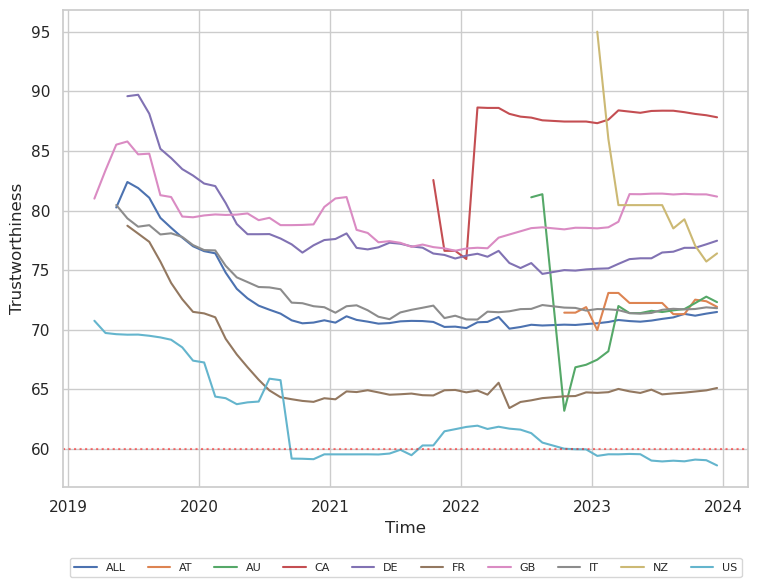

In [94]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=country_score_time, 
             x="file_date", 
             y="Score", 
             hue="Country", 
             estimator="mean")

plt.axhline(y=60, 
            color="red", 
            linestyle="dotted", 
            alpha=0.5)

plt.xlabel("Time")
plt.ylabel("Trustworthiness")
plt.legend(loc="lower center", 
           bbox_to_anchor=(0.5, -0.2), 
           ncol=10, 
           fontsize=8)
plt.tight_layout()

plt.show()

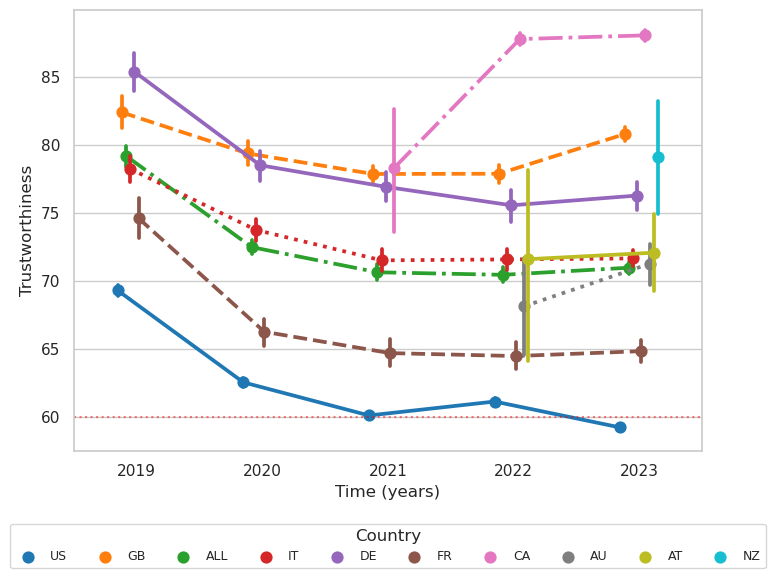

In [95]:
plt.figure(figsize=(8, 6))

country_markers = ["o", "s", "^", "D", "v", "p", "h", "8", ">", "<"]
country_linestyles = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--"]
country_palette = sns.color_palette("tab10", 10)

sns.pointplot(data=df_15,
              x="file_year", 
              y="Score", 
              hue="Country",
              estimator="mean",
              dodge=0.3,
              #markers=country_markers,
              palette=country_palette,
              linestyles=country_linestyles
              )

plt.axhline(y=60, 
            color="red", 
            linestyle="dotted", 
            alpha=0.5)

plt.xlabel("Time (years)")
plt.ylabel("Trustworthiness")

#handles, labels = pointplot.get_legend_handles_labels()
plt.legend(
    #handles, labels,
    title="Country",
    loc="lower center", 
    bbox_to_anchor=(0.5, -0.28), 
    ncol=10, 
    fontsize=9)
plt.tight_layout()

plt.savefig(join(
    figures_path, 
    "f4-scores_over_time_per_country.png"), 
    dpi=300)

plt.show()

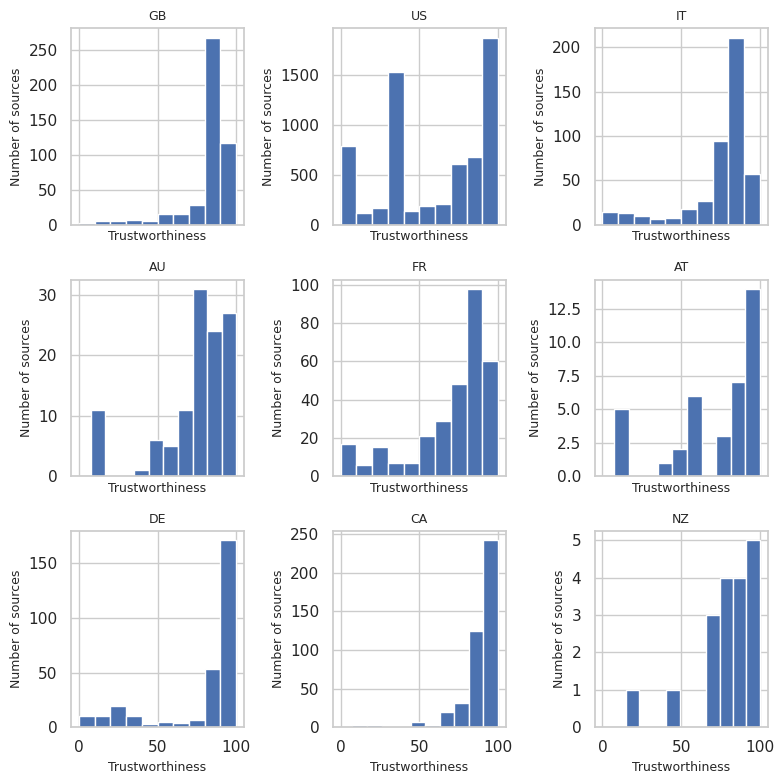

In [96]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=False, sharex=True)
country_df = df_recent[df_recent["Country"] != "ALL"]
 

for i, country in enumerate(country_df["Country"].unique()):
    row = i // 3 
    col_in_row = i % 3  
    df = country_df[country_df["Country"] == country]
    df["Score"].hist(ax=axs[row, col_in_row])
    axs[row, col_in_row].set_xlabel("Trustworthiness", fontsize=9)
    axs[row, col_in_row].set_ylabel("Number of sources", fontsize=9)
    axs[row, col_in_row].set_title(f'{country}', fontsize=9)

plt.tight_layout()

plt.savefig(join(figures_path,"scores_per_country_recent.png"), dpi=300)
plt.show()

In [97]:
#do the same with the number of domains over time
country_domains = df_15\
    .groupby(["Country","file_date"])\
    .size()\
    .reset_index(name="Count")

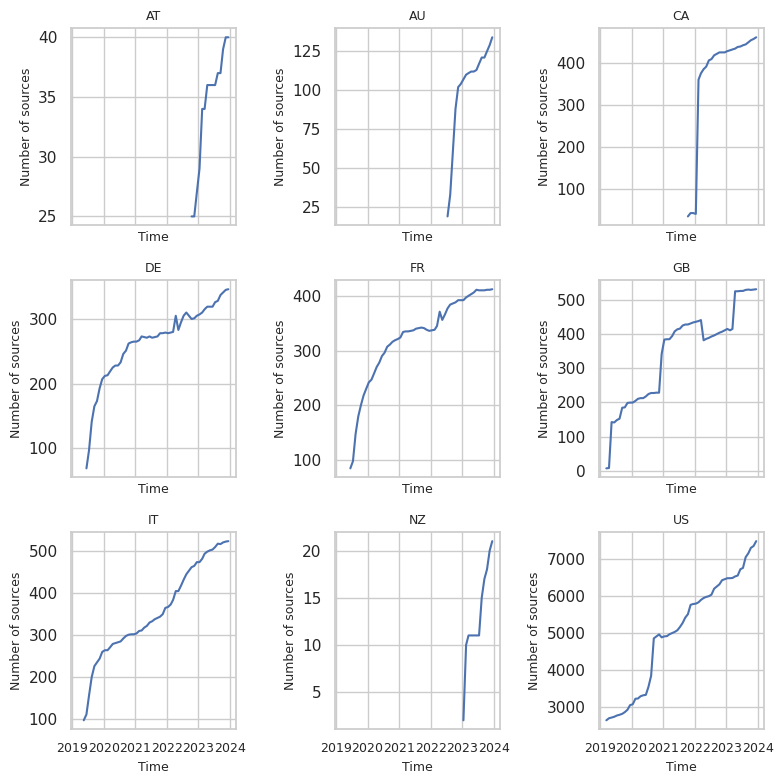

In [98]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=False, sharex=True)
plt.subplots_adjust(hspace=0.5, wspace=0.5)

filtered_countries = country_domains[country_domains["Country"] != "ALL"]["Country"].unique()

for i, country in enumerate(filtered_countries):
    row = i // 3 
    col_in_row = i % 3  
    df = country_domains[country_domains["Country"] == country]  
    axs[row, col_in_row].plot(df["file_date"], df["Count"], label=country)
    axs[row, col_in_row].set_xlabel("Time", fontsize=9)
    axs[row, col_in_row].set_ylabel("Number of sources", fontsize=9)
    axs[row, col_in_row].set_title(f'{country}', fontsize=9)
    axs[row, col_in_row].tick_params(axis="x", labelsize=9)

plt.tight_layout()
plt.savefig(join(figures_path,"n_country_over_time.png"), dpi=300)
plt.show()

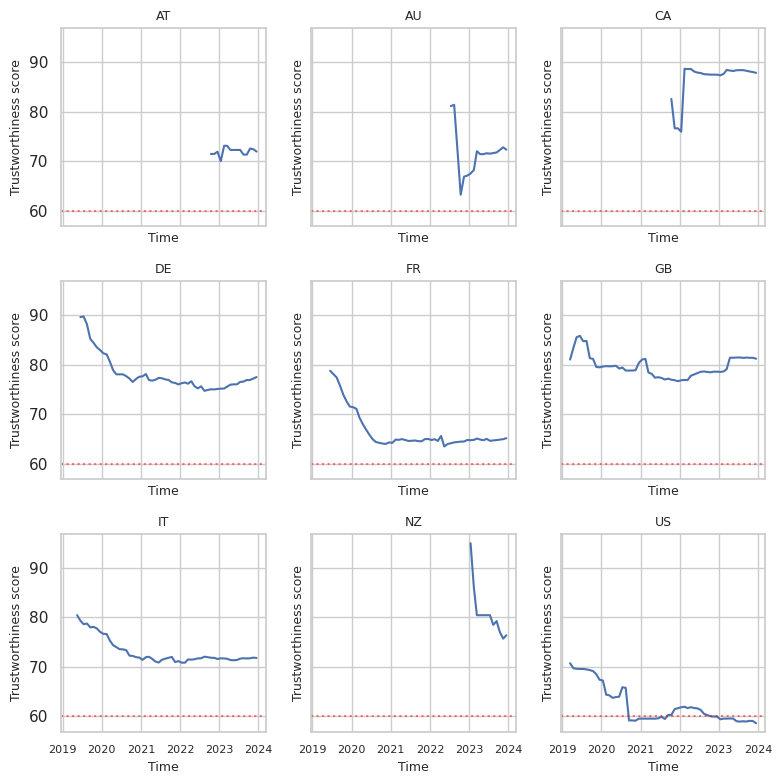

In [99]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=True, sharex=True)
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for i, country in enumerate(filtered_countries):
    row = i // 3 
    col_in_row = i % 3  
    df = country_score_time[country_score_time["Country"] == country]  
    axs[row, col_in_row].plot(df["file_date"], df["Score"], 
                              label=country)
    axs[row, col_in_row].set_xlabel("Time", fontsize=9)
    axs[row, col_in_row].set_ylabel("Trustworthiness score", fontsize=9)
    axs[row, col_in_row].set_title(f'{country}', fontsize=9)
    axs[row, col_in_row].tick_params(axis="x", labelsize=8)
    axs[row, col_in_row].axhline(y=60, color="red", linestyle="dotted", 
                                 alpha=0.5, label="Trustworthiness threshold")

plt.tight_layout()
plt.savefig(join(figures_path,"scores_country_over_time.png"), dpi=300)
plt.show()

### Updates

In [100]:
country_updates_sorted = df_15_UUID\
                            [["Country", "Domain", "Last Updated", "Score"]]\
                            .sort_values(
                                by=["Country", "Domain", "Last Updated"])\
                            .reset_index(drop=True)

In [101]:
country_updates_sorted["Time_Diff"] = country_updates_sorted\
                            .groupby(["Country", "Domain"])\
                            ["Last Updated"]\
                            .diff()

country_updates_sorted["Score_Diff"] = country_updates_sorted\
                            .groupby(["Country", "Domain"])\
                            ["Score"]\
                            .diff()
country_updates_sorted.head(3)

,Country,Domain,Last Updated,Score,Time_Diff,Score_Diff
0,ALL,100giornidaleoni.it,2022-05-23 10:23:51.210,30.0,NaT,NaN
1,ALL,100giornidaleoni.it,2023-05-24 09:25:20.659,30.0,365 days 23:01:29.449000,0.0
2,ALL,2020news.de,2021-04-20 12:24:13.398,20.0,NaT,NaN


In [102]:
time_diff_per_domain = country_updates_sorted\
                                    .groupby(["Country", "Domain"])["Time_Diff"]\
                                    .mean()\
                                    .reset_index()

time_diff_country = time_diff_per_domain.groupby("Country")["Time_Diff"]\
                        .mean()\
                        .reset_index()


#turn into days
time_diff_country["Updates"] = \
    time_diff_country["Time_Diff"]\
        .dt.days.astype(str) + " days"

time_diff_country.drop(columns=["Time_Diff"],
                       inplace=True)

time_diff_country

,Country,Updates
0,ALL,357 days
1,AT,269 days
2,AU,299 days
3,CA,303 days
4,DE,399 days
5,FR,391 days
6,GB,245 days
7,IT,310 days
8,NZ,235 days
9,US,262 days


In [103]:
score_diff_per_domain = country_updates_sorted\
                                    .groupby(["Country", "Domain"])["Score_Diff"]\
                                    .mean()\
                                    .reset_index()

score_diff_per_domain.groupby("Country")["Score_Diff"]\
                        .mean()\
                        .reset_index()

,Country,Score_Diff
0,ALL,0.634753
1,AT,-0.380952
2,AU,0.019663
3,CA,0.849685
4,DE,1.212532
5,FR,0.606437
6,GB,-0.341657
7,IT,0.345701
8,NZ,-4.000000
9,US,-0.285082


In [104]:
country_updates = df_15_UUID\
                    .groupby("Country")["Last Updated"]\
                    .describe(#datetime_is_numeric=True
                    )\
                    .sort_values("count", ascending=False)
country_updates

/tmp/ipykernel_1917152/7169581.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  country_updates = df_15_UUID\
/tmp/ipykernel_1917152/7169581.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  country_updates = df_15_UUID\
/tmp/ipykernel_1917152/7169581.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  country_updates = df_15_UUID\
/tmp/ipykernel_1917152/7169581.py:1: FutureWarning: 

,count,unique,top,freq,first,last
Country,,,,,,
US,37839,32368,2023-09-05 12:35:58.675000,1073,2018-07-20 14:03:17.020000,2023-12-15 03:35:11.655000
ALL,5217,4951,2023-03-03 14:35:17.835000,54,2019-05-13 13:59:57.635000,2023-12-14 21:38:37.013000
GB,2171,1955,2023-04-13 02:16:22.067000,146,2019-01-22 20:08:15.039000,2023-12-15 03:39:54.338000
IT,2148,2021,2023-03-03 14:36:25.074000,54,2019-05-13 13:01:34.990000,2023-12-14 16:46:30.021000
FR,1591,1548,2023-11-29 18:01:29.414000,5,2019-05-22 13:00:05.234000,2023-12-14 21:38:41.307000
DE,1306,1268,2023-09-27 13:22:00.720000,11,2019-05-21 13:00:27.025000,2023-12-13 10:26:08.487000
CA,1104,850,2023-03-07 17:52:14.615000,71,2021-09-28 14:46:52.465000,2023-12-11 16:58:11.809000
AU,251,240,2023-02-24 16:13:47.868000,9,2022-07-01 14:57:02.861000,2023-12-14 06:33:30.642000
AT,66,57,2022-08-25 05:30:11.578000,5,2022-08-24 06:43:10.210000,2023-12-13 10:33:04.632000


In [105]:
#turn Last Updated into year
df_15_UUID["update_year"] = df_15_UUID["Last Updated"].dt.year
year_updates = df_15_UUID\
                .groupby(["Country", "update_year"])\
                .size()\
                .reset_index(name="Update Count")

year_updates.groupby("Country")["Update Count"]\
            .describe()

,count,mean,std,min,25%,50%,75%,max
Country,,,,,,,,
ALL,5.0,1043.4,323.691674,599.0,891.00,1012.0,1351.00,1364.0
AT,2.0,33.0,1.414214,32.0,32.50,33.0,33.50,34.0
AU,2.0,125.5,13.435029,116.0,120.75,125.5,130.25,135.0
CA,3.0,368.0,302.044699,22.0,262.50,503.0,541.00,579.0
DE,5.0,261.2,46.644399,212.0,235.00,261.0,262.00,336.0
FR,5.0,318.2,85.954639,206.0,282.00,327.0,334.00,442.0
GB,5.0,434.2,177.357548,270.0,284.00,453.0,455.00,709.0
IT,5.0,429.6,183.776495,176.0,359.00,415.0,535.00,663.0
NZ,1.0,26.0,NaN,26.0,26.00,26.0,26.00,26.0


In [106]:
filtered_df = country_updates[~country_updates\
                              .index.isin(["US", "ALL"])]
filtered_df["unique"].mean()

995.625

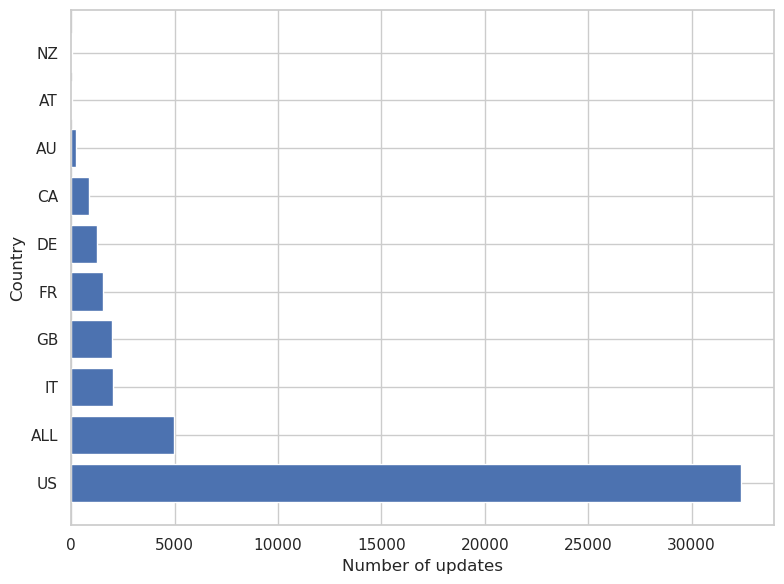

In [107]:
plt.figure(figsize=(8, 6))
country_updates = country_updates\
                    .sort_values("unique", 
                                 ascending=False)

plt.barh(country_updates.index, 
         country_updates["unique"])
plt.xlabel("Number of updates") 
plt.ylabel("Country")
plt.tight_layout()

plt.savefig(join(figures_path, 
                 "updates_per_country.png"), 
                 dpi=300)
plt.show()

In [108]:
unique_updates = df_15_UUID\
                    .groupby(["Country", "file_year"])["Last Updated"]\
                    .nunique()\
                    .reset_index()
unique_updates.columns = ["Country", "Year", "Update intervals"]
unique_updates["Year"] = unique_updates["Year"]\
                            .astype(str)

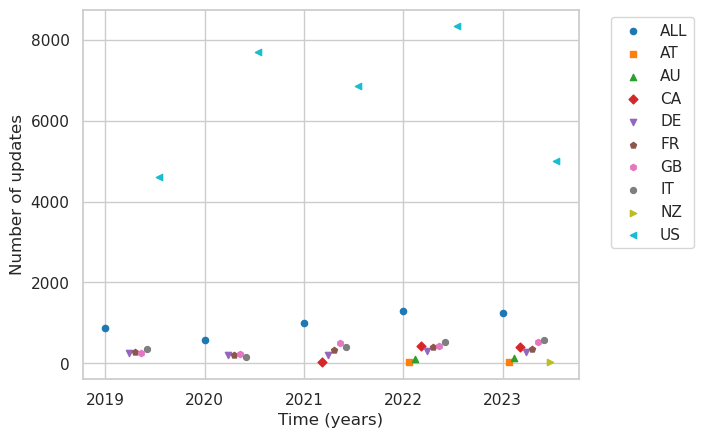

In [111]:
dodge = 0.06
unique_updates["Year"] = pd.to_numeric(
                                unique_updates["Year"], 
                                errors="coerce")

for i, country in enumerate(unique_updates["Country"].unique()):
    country_df = unique_updates[\
                    unique_updates["Country"] == country]
    plt.scatter(
            country_df["Year"] + i * dodge, 
            country_df["Update intervals"], 
            label=country, 
            marker=country_markers[i % len(country_markers)],  
            color=country_palette[i % len(country_palette)],
            s=20)
plt.xlabel("Time (years)")
plt.ylabel("Number of updates")
plt.legend(bbox_to_anchor=(1.05, 1), 
           loc="upper left")
plt.savefig(join(figures_path, 
                 "updates_per_country_over_time.png"), 
                 dpi=300)
plt.show()

In [112]:
#merge time_diff_per_country with country_means
country_means = country_means\
                    .merge(time_diff_country, 
                           on="Country")
country_means


,Country,n (\%),Trustworthiness (SD),Updates
0,US,6286 (65.77),59.08 (33.81),262 days
1,ALL,1136 (11.89),74.8 (25.29),357 days
2,GB,470 (4.92),83.86 (17.31),245 days
3,IT,459 (4.8),74.09 (21.43),310 days
4,CA,435 (4.55),88.81 (13.79),303 days
5,FR,308 (3.22),70.65 (26.15),391 days
6,DE,292 (3.06),79.92 (29.11),399 days
7,AU,116 (1.21),73.59 (24.83),299 days
8,AT,38 (0.4),71.92 (30.01),269 days
9,NZ,18 (0.19),80.28 (21.66),235 days


In [113]:
table2_latex = country_means\
    .sort_values("Country", ascending=False)\
    .to_latex(
        index=False, 
        escape=False,
        caption="Country Descriptives.",
        label="table:table2", 
        position='H',
        column_format=' X c c c c ',
        longtable=False, 
        header=True, 
        na_rep='---', 
        bold_rows=True)

table2_latex = \
    table2_latex\
        .replace("\\begin{tabular}{", "\\begin{tabularx}{\\textwidth}{")

table2_latex = \
    table2_latex\
        .replace("\\end{tabular}", "\\end{tabularx}")

table2_latex = \
    table2_latex \
        .replace("\\bottomrule", 
                 "\\bottomrule\n" 
                 "\\multicolumn{3}{l}{\\textit{Note.} As of December 15th, 2023. Sorted by size.}"
                 )

with open(join(tables_path, "t2_countries.tex"), 'w') as f:
    f.write(table2_latex)

/tmp/ipykernel_1917152/599855534.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table2_latex = country_means\


In [114]:
#per country i want to see the number of sources that have 1 in a criterion
criteria_country = df_recent\
    .groupby("Country")\
    [criteria_columns_recent.columns]\
    .sum()\
    .reset_index()

sources_counry = \
    df_recent\
        .groupby("Country")\
        .size()\
        .reset_index(name="Total")

criteria_country = \
    criteria_country\
        .merge(sources_counry, 
               on="Country")

for col in criteria_columns_recent.columns:
    criteria_country[col] = \
        criteria_country["Total"] - criteria_country[col] 
    
for col in criteria_columns_recent.columns:
    criteria_country[col] = \
        round(criteria_country[col] / criteria_country["Total"] * 100, 2)

criteria_country\
    .drop(columns="Total", 
          inplace=True)

criteria_country.columns = \
    [col.replace("\n", " ") for col in 
     criteria_country.columns]

criteria_country

,Country,Does not repeatedly publish false or egregiously misleading content,Gathers and presents information responsibly,Handles the difference between news and opinion responsibly,Avoids deceptive headlines,Website discloses ownership and financing,Clearly labels advertising,"Reveals who's in charge, including any possible conflicts of interest","The site provides names of content creators, along with either contact or biographical information",Has effective practices for correcting errors
0,ALL,11.71,20.51,18.40,11.62,32.04,14.96,16.90,62.24,63.91
1,AT,13.16,23.68,23.68,13.16,47.37,15.79,39.47,73.68,50.00
2,AU,10.34,15.52,19.83,11.21,43.97,40.52,46.55,37.07,57.76
3,CA,1.84,4.60,3.45,1.84,46.67,5.75,34.94,29.66,17.47
4,DE,15.75,21.23,17.12,15.41,25.68,6.85,7.88,42.47,33.22
5,FR,13.64,27.60,20.13,13.64,39.94,23.38,18.51,66.88,67.86
6,GB,3.62,10.00,8.94,3.40,17.66,6.17,13.83,19.36,69.15
7,IT,8.50,16.56,19.17,8.28,28.76,12.42,17.65,72.55,81.92
8,NZ,11.11,11.11,5.56,0.00,38.89,16.67,50.00,61.11,38.89
9,US,18.80,47.50,42.38,17.96,64.60,46.07,48.93,51.57,62.50


In [115]:
table3_latex = criteria_country\
    .to_latex(
        index=False, 
        escape=False,
        caption="Criteria per country.",
        label="table:table3", 
        position='H',
        column_format=' l X X X X X X X X X ',
        longtable=False,
        header=True,
        na_rep='---',
        bold_rows=True)

table3_latex = \
    table3_latex\
        .replace("\\begin{tabular}{", "\\begin{tabularx}{\\textwidth}{")
table3_latex = \
    table3_latex\
        .replace("\\end{tabular}", "\\end{tabularx}")

table3_latex = \
    table3_latex\
        .replace("\\bottomrule", 
                 "\\bottomrule\n" 
                 "\\multicolumn{3}{l}{\\textit{Note.} As of December 15th, 2023.}"
                 )

with open(join(tables_path, "t3_criteria_country.tex"), 'w') as f:
    f.write(table3_latex)

/tmp/ipykernel_1917152/2490467276.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table3_latex = criteria_country\


## Overlap with other lists

In [116]:
gond = pd.read_csv("../GONDv1_domains.csv")
gond_de = (gond[gond["language"] == "de"]
           .drop_duplicates(
               subset="domain", 
               keep="first")
)
gond_de.head(3)

,domain,type,language,in_list_chatgpt,in_list_hbi,in_list_scharkow,in_list_stier,in_list_w3news
1,20min.ch,legacy press,de,False,False,False,True,False
7,24rhein.de,digital-born news outlet,de,True,False,False,False,False
8,24vest.de,legacy press,de,False,True,False,False,False


In [117]:
gond["type"]\
    .value_counts(
        normalize=True)

legacy press                0.489102
digital-born news outlet    0.179599
commercial broadcaster      0.101133
hyperpartisan news          0.081953
public broadcaster          0.080209
tabloid newspaper           0.068003
Name: type, dtype: float64

In [118]:
#overlap between gond and newsguard
df15_de = (df_15[df_15["Language"] == "de"]
           .drop_duplicates(
               subset="Domain", 
               keep="first")
)
overlap_de = pd.merge(gond_de, df15_de, 
                   left_on="domain", 
                   right_on="Domain",
                   how="inner")
len(overlap_de)

237

In [119]:
overlap_de_type = overlap_de\
    .groupby("type")\
    .size()\
    .reset_index(name="Count")

overlap_de_type

,type,Count
0,commercial broadcaster,4
1,digital-born news outlet,19
2,hyperpartisan news,24
3,legacy press,157
4,public broadcaster,18
5,tabloid newspaper,15


In [120]:
df15_unique = \
    df_15\
    .drop_duplicates(
        subset="Domain", 
        keep="first")

gond_unqiue = \
    gond\
    .drop_duplicates(
        subset="domain", 
        keep="first")

overlap = pd.merge(gond, df15_unique, 
                   left_on="domain", 
                   right_on="Domain",
                   how="inner")

len(overlap)

543

In [121]:
#per type of source, what is the overlap?
overlap_type = overlap\
    .groupby("type")\
    .size()\
    .reset_index(name="Count")

overlap_type 

,type,Count
0,commercial broadcaster,58
1,digital-born news outlet,65
2,hyperpartisan news,56
3,legacy press,285
4,public broadcaster,40
5,tabloid newspaper,39


In [122]:
overlap_lang = overlap\
    .groupby("language")\
    .size()\
    .reset_index(name="Count")

overlap_lang

,language,Count
0,af,1
1,de,241
2,el,1
3,en,147
4,es,3
5,fr,47
6,it,56
7,ja,1
8,ka,1
9,no,1


In [123]:
#what are the sources in de that dont overlap?
df15_de_unique = df15_de[~df15_de["Domain"].isin(overlap_de["Domain"])]
df15_de_unique["Domain"]

2696                    dw.com
2736                    web.de
2757                   gmx.net
2815          handelsblatt.com
3180            deutsch.rt.com
                 ...          
357                    5min.at
741               telepolis.de
753      nachrichten-heute.net
5186          de.news-front.su
10762              gesund24.at
Name: Domain, Length: 165, dtype: object

In [124]:
overlap_de[overlap_de["type"] == "hyperpartisan news"]

,domain,type,language,in_list_chatgpt,in_list_hbi,in_list_scharkow,in_list_stier,in_list_w3news,UUID,Domain,...,ANDROIDAPP,OTHER,Contact Mail Form URL.1,Communities Served,BrandGuard Segments,False Narratives,Does not repeatedly publish false or egregiously misleading content,Has effective practices for correcting errors,file_year,file_month
5,achgut.com,hyperpartisan news,de,False,False,False,True,False,8d254403-389a-4ee6-96e2-ae96ce0b8fa3,achgut.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,2020-04
9,anonymousnews.org,hyperpartisan news,de,True,False,False,False,False,29e6284a-fbb5-49b7-8f71-cac2dff799be,anonymousnews.org,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,2022-01
10,anonymousnews.ru,hyperpartisan news,de,False,False,False,True,False,6522c342-6f9b-460a-b589-cba52978e7a1,anonymousnews.ru,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,2019-09
12,anti-spiegel.ru,hyperpartisan news,de,True,False,False,False,False,22e39de9-9b77-4b36-9230-f43841866963,anti-spiegel.ru,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,2020-01
37,corona-blog.net,hyperpartisan news,de,True,False,False,False,False,feaf8a6d-d78e-47a7-ad41-e1c2ecd5176c,corona-blog.net,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021,2021-07
44,deutsche-wirtschafts-nachrichten.de,hyperpartisan news,de,False,False,False,True,False,cdec7db3-677e-467a-a5f0-971a5911461a,deutsche-wirtschafts-nachrichten.de,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,2020-11
53,epochtimes.de,hyperpartisan news,de,False,False,False,True,True,5ca37cc0-f6c9-4c8b-b3d9-7e617e283133,epochtimes.de,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,2019-06
56,exxpress.at,hyperpartisan news,de,True,False,False,False,False,a0cf47df-0e42-497e-b4e5-98b38dfc75f0,exxpress.at,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021,2021-10
62,freiewelt.net,hyperpartisan news,de,False,False,False,True,False,2cfd39d8-2793-45d7-870c-e5d538c111ab,freiewelt.net,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,2019-12
87,journalistenwatch.com,hyperpartisan news,de,True,False,False,False,False,8bef4628-e50a-4919-b740-b44a9cfab612,journalistenwatch.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,2019-08


## Political Orientation

In [125]:
print(f'Out of {len(df_15)} rows, '
      f'{df_15["Orientation"].isnull().sum()} '
      'have no rating for orientation.')
print(f'Out of {len(df_15_UUID)} unique ratings, '
      f'{df_15_UUID["Orientation"].isnull().sum()} '
      'have no rating for orientation.')
print(f'This is {round(df_15_UUID["Orientation"].isnull().sum()/len(df_15_UUID)*100,2)}% '
      'of the unique ratings.')

Out of 421870 rows, 283907 have no rating for orientation.
Out of 51719 unique ratings, 29913 have no rating for orientation.
This is 57.84% of the unique ratings.


In [126]:
print(f'In the most recent database, '
      f'{df_recent["Orientation"].isnull().sum()} '
      'have no rating for orientation.\n'
      f'Out of {len(df_recent)} rows, '
      f'{df_recent["Orientation"].notnull().sum()} have a rating.\n'
      f'This is {round(df_recent["Orientation"].notnull().sum()/len(df_recent)*100,2)}% '
      'of the unique ratings.')

In the most recent database, 6578 have no rating for orientation.
Out of 9558 rows, 2980 have a rating.
This is 31.18% of the unique ratings.


In [ ]:
total_per_country = \
    df_recent\
        .groupby("Country")\
        .size()\
        .reset_index(name="Total")

orientation_count = \
    df_recent[df_recent["Orientation"].notnull()]\
        .groupby("Country")\
        .size()\
        .reset_index(name="Orientation")

country_counts = \
    total_per_country\
        .merge(orientation_count, 
               on="Country", 
               how="left")

country_counts["Percentage"] = \
    round((country_counts["Orientation"] / country_counts["Total"]) * 100,2)

country_counts

,Country,Total,Orientation,Percentage
0,ALL,1136,153,13.47
1,AT,38,10,26.32
2,AU,116,21,18.10
3,CA,435,14,3.22
4,DE,292,47,16.10
5,FR,308,47,15.26
6,GB,470,46,9.79
7,IT,459,53,11.55
8,NZ,18,3,16.67
9,US,6286,2586,41.14


In [127]:
#count orientation per country
orientation_countries = \
    df_recent\
        .groupby("Country")["Orientation"]\
        .value_counts()\
        .unstack(fill_value=1)

#add number of orientation ratings per country
orientation_countries["Total"] = \
    df_recent\
        .groupby("Country")["Orientation"]\
        .count()
        

orientation_countries["% right"] = \
    (orientation_countries["Right"]/orientation_countries["Total"]*100)\
        .round(2)


orientation_countries["Right"] = \
    orientation_countries["Right"].astype(str) + \
    " (" + orientation_countries["% right"].astype(str) + ")"

orientation_countries["% left"] = \
    (orientation_countries["Left"]/orientation_countries["Total"]*100)\
        .round(2)

orientation_countries["Left"] = \
    orientation_countries["Left"].astype(str) + \
    " (" + orientation_countries["% left"].astype(str) + ")"

#drop columns
orientation_countries = \
    orientation_countries\
        .drop(["% right", "% left"], axis=1)\
        .rename(columns={"Left":"Left (%)", "Right":"Right (%)"})

orientation_countries

Orientation,Left (%),Right (%),Total
Country,,,
ALL,36 (23.53),117 (76.47),153
AT,2 (20.0),8 (80.0),10
AU,8 (38.1),13 (61.9),21
CA,4 (28.57),10 (71.43),14
DE,9 (19.15),38 (80.85),47
FR,16 (34.04),31 (65.96),47
GB,22 (47.83),24 (52.17),46
IT,11 (20.75),42 (79.25),53
NZ,1 (33.33),2 (66.67),3


In [128]:
#latex table
table4_latex = \
    orientation_countries\
        .to_latex(index=True, 
                  escape=False,
                  caption="\\textbf{Orientation per country.}",
                  label="table:table4", 
                  position='H',
                  column_format=' X c c c',
                  longtable=False, 
                  header=True, 
                  na_rep='---', 
                  bold_rows=True)

table4_latex = \
    table4_latex\
        .replace("\\begin{tabular}{", 
                 "\\begin{tabularx}{\\textwidth}{")
table4_latex = \
    table4_latex\
        .replace("\\end{tabular}", 
                 "\\end{tabularx}")

table4_latex = \
    table4_latex\
        .replace("\\bottomrule", 
                 "\\bottomrule\n"
                 "\\multicolumn{5}{l}{\\textit{Note.} As of December 15h, 2023.}")

#replace all % with \%
table4_latex = \
    table4_latex\
        .replace("%", "\%")

with open(join(tables_path, 
               "t4_orientation_countries.tex"), 
               'w') as f:
    f.write(table4_latex)

/tmp/ipykernel_1917152/3297875217.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  orientation_countries\


### Over time

<Axes: xlabel='file_month'>

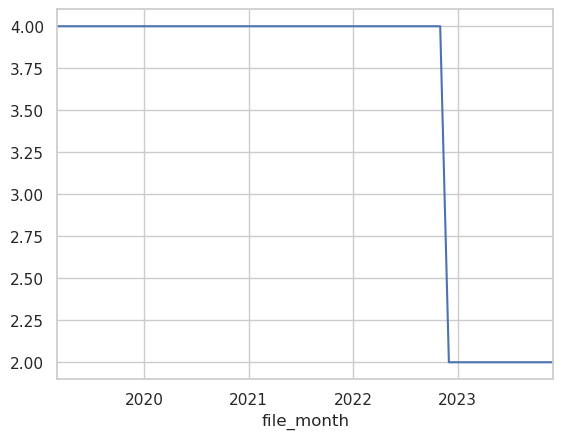

In [129]:
df_15\
    .groupby("file_month")["Orientation"]\
    .nunique()\
    .plot(kind="line")

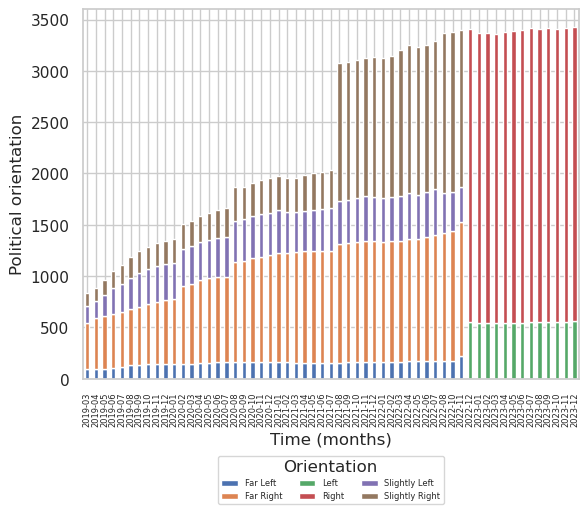

In [130]:
df_15\
    .groupby("file_month")["Orientation"]\
    .value_counts(normalize=False)\
    .unstack()\
    .plot(kind="bar", stacked=True)

plt.xlabel("Time (months)")
plt.ylabel("Political orientation")
plt.xticks(fontsize=6)
plt.legend(title="Orientation", 
           loc="lower center", 
           bbox_to_anchor=(0.5, -0.35), 
           ncol=3, fontsize=6)

plt.savefig(join(figures_path,"orientation_over_time.png"), 
            dpi=300)

In [131]:
orientation_year = \
    df_15\
        .groupby(["Country", "file_date"])["Orientation"]\
        .value_counts()

orientation_year = pd.DataFrame(orientation_year)
orientation_year.columns = ["Count"]
orientation_year = orientation_year.reset_index()
orientation_year = orientation_year[orientation_year["Country"] != "ALL"]
orientation_year

,Country,file_date,Orientation,Count
193,AT,2022-10-15 01:00:00,Far Right,3
194,AT,2022-10-15 01:00:00,Slightly Left,2
195,AT,2022-10-15 01:00:00,Slightly Right,1
196,AT,2022-11-15 01:00:00,Far Right,3
197,AT,2022-11-15 01:00:00,Slightly Left,2
...,...,...,...,...
1319,US,2023-10-15 01:00:00,Left,371
1320,US,2023-11-15 01:00:00,Right,2469
1321,US,2023-11-15 01:00:00,Left,373
1322,US,2023-12-15 01:00:00,Right,2476


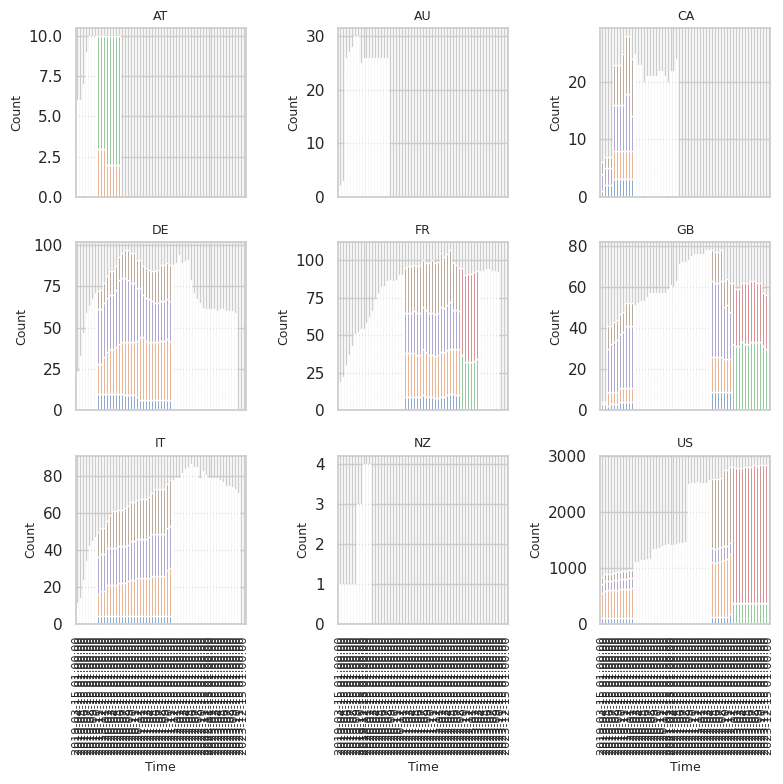

In [136]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=False, sharex=True)
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for i, country in enumerate(orientation_year["Country"].unique()):
    row = i // 3 
    col_in_row = i % 3  
    df = orientation_year[orientation_year["Country"] == country]  
    pivot_df = df.pivot(index="file_date", columns="Orientation", values="Count").fillna(0)
    pivot_df.plot(kind="bar", stacked=True, legend=False, ax=axs[row, col_in_row])
    axs[row, col_in_row].set_xlabel("Time", fontsize=9)
    axs[row, col_in_row].set_ylabel("Count", fontsize=9)
    axs[row, col_in_row].set_title(f'{country}', fontsize=9)
    axs[row, col_in_row].tick_params(axis="x", labelsize=8)

plt.tight_layout()
plt.show()

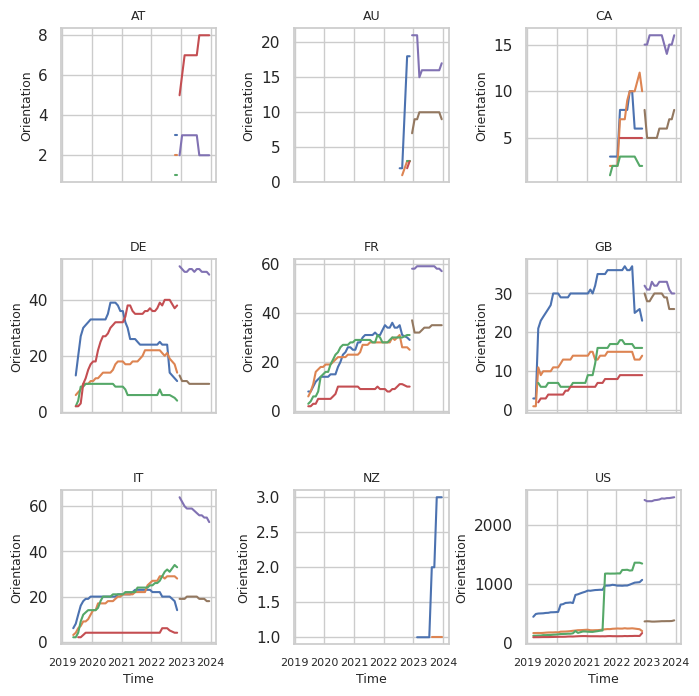

In [132]:
#visualize the orientation over time
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=False, sharex=True)
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for i, country in enumerate(orientation_year["Country"].unique()):
    row = i // 3 
    col_in_row = i % 3  
    df = orientation_year[orientation_year["Country"] == country]  
    sns.lineplot(data=df, 
                 x="file_date", 
                 y="Count", 
                 hue="Orientation",
                 ax=axs[row, col_in_row])
    axs[row, col_in_row].set_xlabel("Time", fontsize=9)
    axs[row, col_in_row].set_ylabel("Orientation", fontsize=9)
    axs[row, col_in_row].set_title(f'{country}', fontsize=9)
    axs[row, col_in_row].tick_params(axis="x", labelsize=8)
    axs[row, col_in_row].legend().remove()

#### add country-specific plot?

In [ ]:
for df in [df_15, df_15_UUID]:
    df["Orientation_bi"] = df["Orientation"]\
        .replace(
        {"Far Left": "Left", "Slightly Left": "Left", 
         "Slightly Right": "Right", 
         "Far Right": "Right"})

left_right_count = df_15["Orientation_bi"]\
    .value_counts()\
    .reset_index()

left_right_count["%"] = \
    (left_right_count["Orientation_bi"] / left_right_count["Orientation_bi"].sum() * 100)\
        .round(2)

left_right_count

,index,Orientation_bi,%
0,Right,107575,77.97
1,Left,30388,22.03


In [ ]:
score_x_orientation_time = df_15\
    .groupby(["file_date", "Orientation"])["Score"]\
    .agg(["mean", "std"])

score_x_orientation_time.tail(2)

mean        std
file_date           Orientation                      
2023-12-15 01:00:00 Left         61.113514  25.991107
                    Right        27.364066  20.423941

In [ ]:
score_x_orientation_time_bi = df_15\
    .groupby(["file_date", "Orientation_bi"])["Score"]\
    .agg(["mean", "std"])

score_x_orientation_time_bi\
    .groupby("Orientation_bi")["mean"]\
    .mean() 

Orientation_bi
Left     71.089262
Right    28.007480
Name: mean, dtype: float64

In [ ]:
score_x_orientation_time_bi\
    .groupby("Orientation_bi")["std"]\
    .mean()

Orientation_bi
Left     25.212816
Right    26.564160
Name: std, dtype: float64

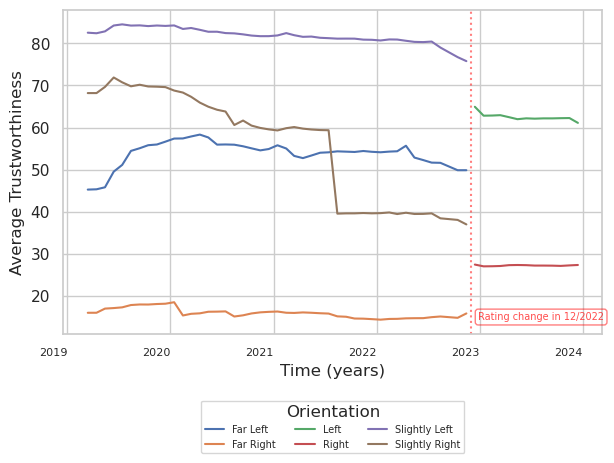

In [ ]:
ax = score_x_orientation_time["mean"]\
    .unstack()\
    .plot(kind="line")
plt.xlabel("Time (years)")
plt.ylabel("Average Trustworthiness")
plt.xticks(fontsize=8)
plt.axvline(x="2022-12", 
            color="red", 
            linestyle="dotted", 
            alpha=0.5)

xmin, xmax = ax.get_xlim()

#add text to axvline
ax.text(xmax - 440, 15, "Label change in 12/2022", 
        fontsize=7, 
        color="red",
        alpha=0.7,
        verticalalignment="center", 
        bbox=dict(facecolor="none", edgecolor="red",
                  boxstyle="round,pad=0.3",
                  alpha=0.5))

ax.legend(title="Orientation", 
          loc="lower center", 
          bbox_to_anchor=(0.5, -0.38), 
          ncol=3, 
          fontsize=7)

plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(join(figures_path,
                 "f5-scores_orientation_over_time.png"),
            dpi=300)

In [ ]:
score_x_orientation_time\
    .loc["2021-06":"2021-08"]

mean        std
file_date           Orientation                         
2021-06-15 01:00:00 Far Left        54.022876  27.760272
                    Far Right       15.903256  20.758654
                    Slightly Left   81.323821  18.353697
                    Slightly Right  59.407563  30.834733
2021-07-15 01:00:00 Far Left        54.123377  27.659420
                    Far Right       15.826350  20.701533
                    Slightly Left   81.230488  18.446345
                    Slightly Right  59.368493  30.881606
2021-08-15 01:00:00 Far Left        54.353896  27.642733
                    Far Right       15.164336  19.691632
                    Slightly Left   81.118644  18.406131
                    Slightly Right  39.556597  20.297690

In [ ]:
score_x_orientation_time\
    .groupby("Orientation")["mean"]\
    .describe()

,count,mean,std,min,25%,50%,75%,max
Orientation,,,,,,,,
Far Left,44.0,53.824213,3.076220,45.268421,52.841395,54.362483,55.795686,58.331081
Far Right,44.0,15.937800,1.131637,14.377902,15.044728,15.892768,16.291120,18.518341
Left,13.0,62.484190,0.872396,61.113514,62.181319,62.229358,62.821229,64.938757
Right,13.0,27.240150,0.125276,27.039936,27.146089,27.223841,27.323509,27.462526
Slightly Left,44.0,81.876337,1.836099,75.776119,80.925754,81.864086,82.940109,84.511070
Slightly Right,44.0,56.128234,12.813416,37.000328,39.665662,59.883686,68.188914,71.892638


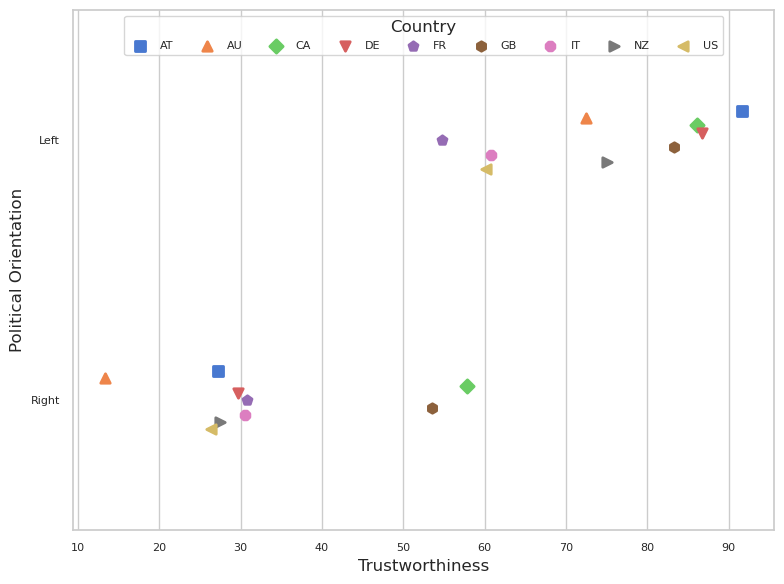

In [ ]:
plt.figure(figsize=(8, 6))

country_markers = ["s", "^", "D", "v", "p", "h", "8", ">", "<"]

sns.pointplot(x="Score", y="Orientation", 
               hue="Country", 
               data=df_15[df_15["Country"] != 'ALL'], 
               markers=country_markers,
               order=["Left", "Right"],
               hue_order=sorted(df_15[df_15["Country"] != 'ALL']["Country"].unique()),
               palette="muted", 
               errorbar=None,
               #split=False,
               #width=0.8
               dodge=True,
               join=False)

plt.xlabel("Trustworthiness")
plt.xticks(fontsize=8)
plt.ylabel("Political Orientation")
plt.yticks(fontsize=8)
plt.legend(title="Country", 
           loc="upper center", 
           ncol=9, 
           fontsize=8)
plt.tight_layout()
plt.savefig(join(figures_path, 
                 "f6-scores_orientation_country.png"), 
            dpi=300)
plt.show()

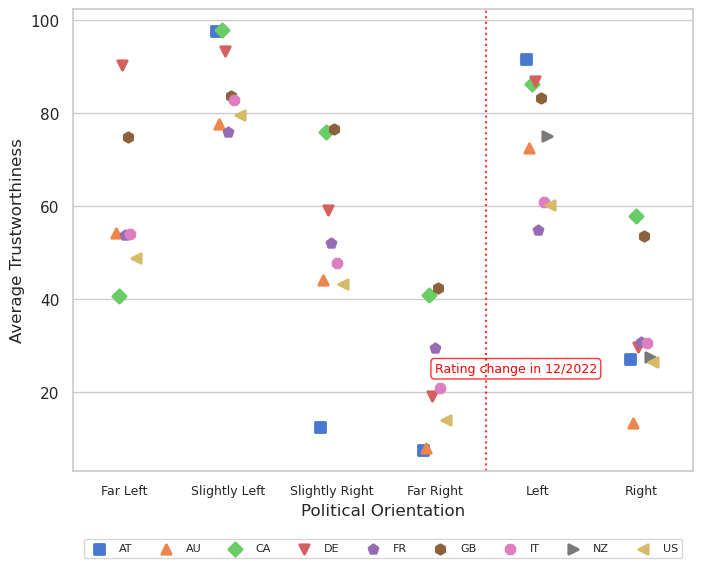

In [ ]:
plt.figure(figsize=(8, 6))

country_markers = ["s", "^", "D", "v", "p", "h", "8", ">", "<"]

sns.pointplot(x="Orientation", y="Score", 
               hue="Country", 
               data=df_15[df_15["Country"] != 'ALL'], 
               markers=country_markers,
               order=["Far Left", "Slightly Left", 
                      "Slightly Right", "Far Right", 
                      "Left", "Right"],
               hue_order=sorted(df_15[df_15["Country"] != 'ALL']["Country"].unique()),
               palette="muted", 
               errorbar=None,
               #split=False,
               #width=0.8
               dodge=True,
               join=False)

plt.axvline(x=3.5,
            color="red", 
            linestyle="dotted", 
            alpha=0.8)
plt.xlabel("Political Orientation")
plt.xticks(fontsize=9)
plt.ylabel("Average Trustworthiness")

#add a text box to line
plt.text(3, 25, "Rating change in 12/2022", 
         fontsize=9, 
         color="red",
         verticalalignment="center", 
         bbox=dict(facecolor="none", edgecolor="red",
                   boxstyle="round,pad=0.3",
                   alpha=0.8))

#legend below
plt.legend(loc="lower center", 
           bbox_to_anchor=(0.5, -0.2), 
           ncol=9, fontsize=8)

plt.savefig(join(figures_path,
                 "scores_orientation_per_country-time.png"),
                 dpi=300)

plt.show()

In [ ]:
#country average score per orientation over time
score_x_orientation_time_country = df_15\
    .groupby(["Country", "file_date", "Orientation_bi"])["Score"]\
    .agg(['mean', 'std'])\
    .reset_index()
score_x_orientation_time_country.head()

,Country,file_date,Orientation_bi,mean,std
0,ALL,2019-05-15 01:00:00,Left,89.285714,10.676521
1,ALL,2019-05-15 01:00:00,Right,46.400000,33.881042
2,ALL,2019-06-15 01:00:00,Left,91.370968,9.283469
3,ALL,2019-06-15 01:00:00,Right,62.666667,36.081028
4,ALL,2019-07-15 01:00:00,Left,88.404255,15.537696


In [ ]:
countries = \
    score_x_orientation_time_country['Country']\
    .unique()
filtered_countries = countries[countries != "ALL"]

In [ ]:
score_x_orientation_time_country

,Country,file_date,Orientation_bi,mean,std
0,ALL,2019-05-15 01:00:00,Left,89.285714,10.676521
1,ALL,2019-05-15 01:00:00,Right,46.400000,33.881042
2,ALL,2019-06-15 01:00:00,Left,91.370968,9.283469
3,ALL,2019-06-15 01:00:00,Right,62.666667,36.081028
4,ALL,2019-07-15 01:00:00,Left,88.404255,15.537696
...,...,...,...,...,...
789,US,2023-10-15 01:00:00,Right,26.472052,19.131685
790,US,2023-11-15 01:00:00,Left,60.146739,22.831427
791,US,2023-11-15 01:00:00,Right,26.551871,19.219462
792,US,2023-12-15 01:00:00,Left,58.368074,23.556327


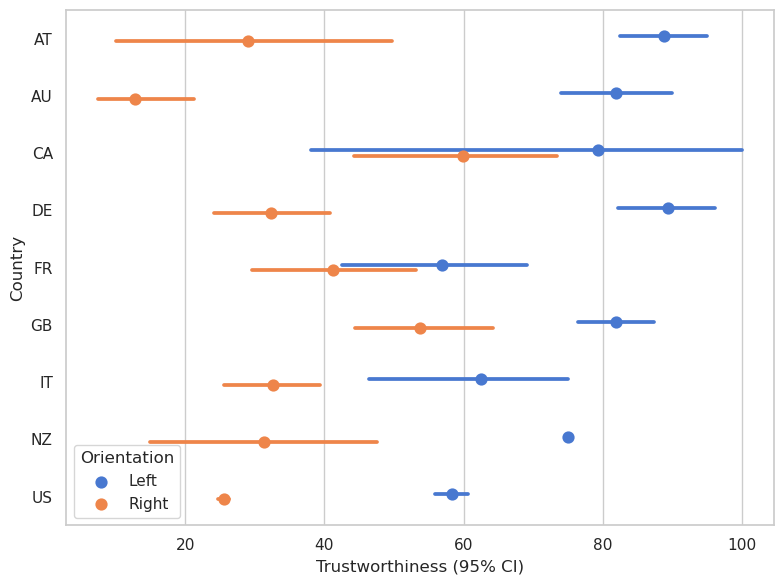

In [ ]:
plt.figure(figsize=(8, 6))
country_diff = df_recent[df_recent["Country"] != "ALL"]

sns.pointplot(
    data=country_diff, 
    y="Country", 
    x="Score", 
    hue="Orientation", 
    hue_order=["Left", "Right"],
    order=sorted(country_diff["Country"].unique()),
    errorbar="ci",
    palette="muted",
    join=False,
    dodge=0.1)

plt.xlabel("Trustworthiness (95% CI)")
plt.ylabel("Country")
plt.tight_layout()
plt.savefig(join(figures_path,
                    "fa4-scores_orientation_per_country_95.png"),
                    dpi=300)
plt.show()

In [ ]:
df_recent\
    .groupby("Orientation")["Score"]\
    .describe()

,count,mean,std,min,25%,50%,75%,max
Orientation,,,,,,,,
Left,423.0,61.676123,23.357774,7.5,39.5,62.5,80.0,100.0
Right,2557.0,26.654478,20.134820,0.0,7.5,32.0,32.0,100.0


In [ ]:
ttest_recent = \
    stats\
        .ttest_ind(
            df_recent[df_recent["Orientation"] == "Left"]["Score"], 
            df_recent[df_recent["Orientation"] == "Right"]["Score"],
            nan_policy="omit")

ttest_recent

TtestResult(statistic=32.35409531400827, pvalue=4.6620855020667373e-197, df=2978.0)

## Topics

In [ ]:
print(
    f'Out of {len(df_recent)} ratings, '
    f'there are {df_recent["Topics"].isnull().sum()} without topic. ')

print(
    f'This makes up {round(df_recent["Topics"].isnull().sum()/len(df_recent)*100,2)}% ')

Out of 9558 ratings, there are 161 without topic. 
This makes up 1.68% 


<Axes: xlabel='file_date'>

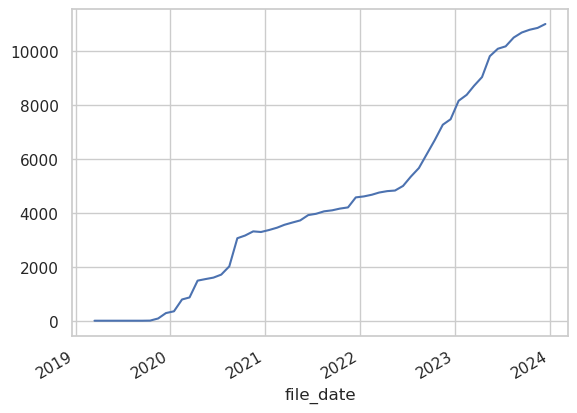

In [ ]:
df_15\
    .groupby("file_date")["Topics"]\
    .count()\
    .plot(kind="line")

In [ ]:
recent_topics_df = \
    df_recent[[
        "Domain", "Country", "Topics",
        "Orientation", "Score", "Rating"]]

recent_topics_df\
    .reset_index(drop=True, 
                 inplace=True)  

recent_topics_df["Topics"] = \
    df_recent["Topics"]\
        .str.split(",")  #split topics into lists

recent_topics_df.head(3)

/tmp/ipykernel_1727229/3048149922.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_topics_df["Topics"] = \


,Domain,Country,Topics,Orientation,Score,Rating
0,peterboroughtoday.co.uk,GB,"[Local News, General News]",NaN,82.5,T
1,mycharisma.com,US,[Religion],NaN,49.5,N
2,charismamag.com,US,[Religion],NaN,49.5,N


In [ ]:
recent_topics_df = \
    recent_topics_df\
        .explode("Topics")\
        .reset_index(drop=True)

recent_topics_df.head(3)

,Domain,Country,Topics,Orientation,Score,Rating
0,peterboroughtoday.co.uk,GB,Local News,NaN,82.5,T
1,peterboroughtoday.co.uk,GB,General News,NaN,82.5,T
2,mycharisma.com,US,Religion,NaN,49.5,N


In [ ]:
recent_topic_count = \
    recent_topics_df\
        .groupby("Topics")\
        .size()\
        .reset_index()

recent_topic_count["%"] = \
    (recent_topic_count[0] / len(df_recent) * 100)\
        .round(2)

recent_topic_count\
    .columns = ["Topics", "Count", "%"]

recent_topic_avg = \
    recent_topics_df\
        .groupby("Topics")["Score"]\
        .agg(["mean", "std"])\
        .reset_index()\
        .round(2)

recent_topic_avg\
    .columns = ["Topics", "Score", "SD"]

recent_topic_desc = \
    pd.merge(recent_topic_count,
             recent_topic_avg,
            on="Topics")

recent_topic_desc

,Topics,Count,%,Score,SD
0,Business or Personal Finance,393,4.11,76.44,27.89
1,Celebrity news,212,2.22,74.28,30.86
2,Conspiracy theories or hoaxes,909,9.51,68.27,31.42
3,Criminal justice,20,0.21,73.25,24.62
4,Education,20,0.21,73.75,29.71
5,Entertainment,281,2.94,73.65,30.34
6,Environment,53,0.55,64.89,29.83
7,Fashion,78,0.82,74.12,31.26
8,General News,1900,19.88,68.08,30.29
9,Health or medical information,1006,10.53,67.75,31.48


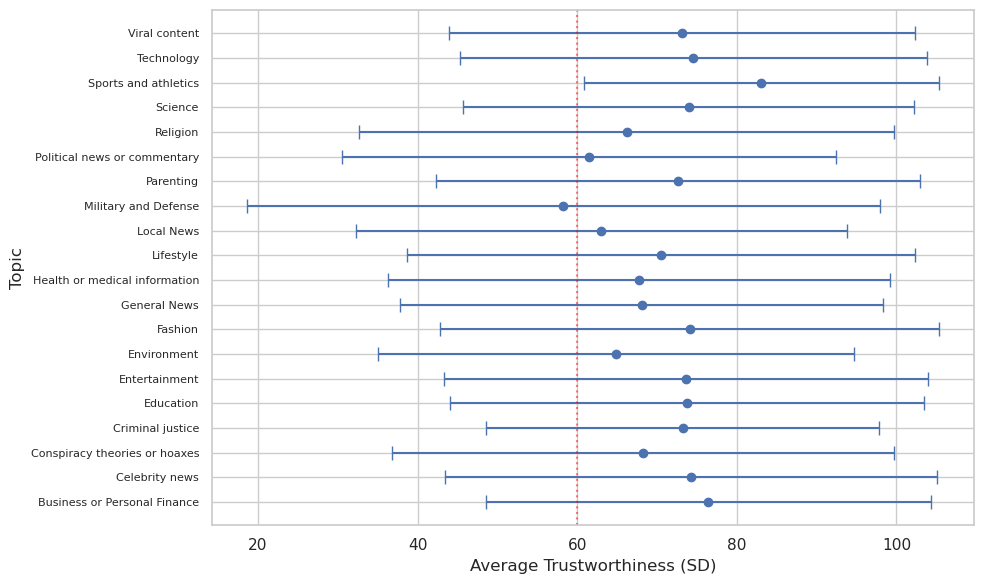

In [ ]:
plt.figure(figsize=(10, 6))
plt.errorbar(y=recent_topic_desc["Topics"],
            x=recent_topic_desc["Score"],
            xerr=recent_topic_desc["SD"],
            fmt="o", capsize=5)

plt.axvline(x=60, 
            color="red", 
            linestyle="dotted", 
            label="Trustworthiness threshold", 
            alpha=0.5)

plt.xlabel("Average Trustworthiness (SD)")
plt.ylabel("Topic")
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig(join(figures_path, 
                 "f7-topics_score_recent.png"), 
                 dpi=300)
plt.show()

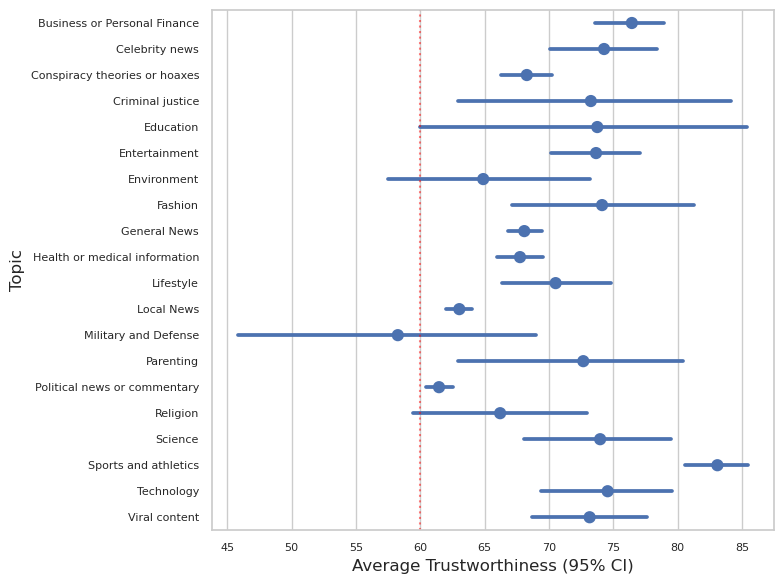

In [ ]:
#turn into sns plot with 95% ci
plt.figure(figsize=(8, 6))
sns.pointplot(data=recent_topics_df, 
            y="Topics", 
            x="Score",
            join=False,
            #can i order according to the mean?
            order=recent_topic_desc["Topics"],
            errorbar="ci")

plt.axvline(x=60, 
            color="red", 
            linestyle="dotted", 
            label="Trustworthiness threshold", 
            alpha=0.5)

plt.xlabel("Average Trustworthiness (95% CI)")
plt.ylabel("Topic")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.tight_layout()

plt.savefig(join(figures_path, 
                 "f7-topics_score_recent-95ci.png"), 
                 dpi=300)

In [ ]:
#get list of domains with rating N
bad_domains = recent_topics_df\
    [recent_topics_df["Rating"] == "N"]\
    ["Domain"].unique()

len(bad_domains)

3209

In [ ]:
topics_bad = recent_topics_df\
        .groupby(["Topics", "Rating"])["Domain"]\
        .nunique()\
        .unstack(fill_value=0)\
        .reset_index()\
        .sort_values(by="N", ascending=False)

#add percentage of good vs bad
topics_bad["% N"] = \
    (topics_bad["N"] / len(bad_domains) * 100)\
        .round(2)

topics_bad

Rating,Topics,N,T,% N
14,Political news or commentary,1592,1726,49.61
11,Local News,1463,1971,45.59
8,General News,534,1243,16.64
9,Health or medical information,345,583,10.75
2,Conspiracy theories or hoaxes,301,530,9.38
0,Business or Personal Finance,67,287,2.09
5,Entertainment,64,205,1.99
10,Lifestyle,56,149,1.75
1,Celebrity news,45,160,1.40
19,Viral content,39,122,1.22


In [ ]:
#how many of bad domains cover each topic?
bad_domains_topics = recent_topics_df\
    [recent_topics_df["Domain"].isin(bad_domains)]\
    .groupby("Topics")["Domain"]\
    .nunique()\
    .reset_index()

bad_domains_topics["%"] = \
    (bad_domains_topics["Domain"] / len(bad_domains) * 100)\
        .round(2)

bad_topics = bad_domains_topics\
    .sort_values(by="Domain", ascending=False)\
    .head(5)

bad_topics

,Topics,Domain,%
14,Political news or commentary,1592,49.61
11,Local News,1463,45.59
8,General News,534,16.64
9,Health or medical information,345,10.75
2,Conspiracy theories or hoaxes,301,9.38


### Over time

In [ ]:
topics_df = \
    df_15[[
        "file_date", "UUID",
        "Domain", "Country", "Topics",
        "Orientation", "Score", "Rating"]]

topics_df\
    .reset_index(drop=True, 
                 inplace=True)  

topics_df["Topic"] = \
    topics_df["Topics"]\
        .str.split(",")  #split topics into lists

topics_df = \
    topics_df\
        .explode("Topic")\
        .reset_index(drop=True)
topics_df.tail(3)

/tmp/ipykernel_1727229/805052536.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topics_df["Topic"] = \


,file_date,UUID,Domain,Country,Topics,Orientation,Score,Rating,Topic
578180,2023-11-15 01:00:00,38ffb203-ebe5-4cac-8b5a-f84dd3697faf,blog.halle-leaks.de,DE,"Conspiracy theories or hoaxes,Political news o...",Right,37.5,N,Political news or commentary
578181,2023-11-15 01:00:00,954dfb48-6052-4e16-baaf-3f12dfb2ccce,blog.halle-leaks.de,ALL,"Conspiracy theories or hoaxes,Political news o...",Right,37.5,N,Conspiracy theories or hoaxes
578182,2023-11-15 01:00:00,954dfb48-6052-4e16-baaf-3f12dfb2ccce,blog.halle-leaks.de,ALL,"Conspiracy theories or hoaxes,Political news o...",Right,37.5,N,Political news or commentary


In [ ]:
#topic frequency over time
topic_freq = topics_df\
    .groupby(["file_date", "Topic"])\
    .size()\
    .reset_index(name="Count")

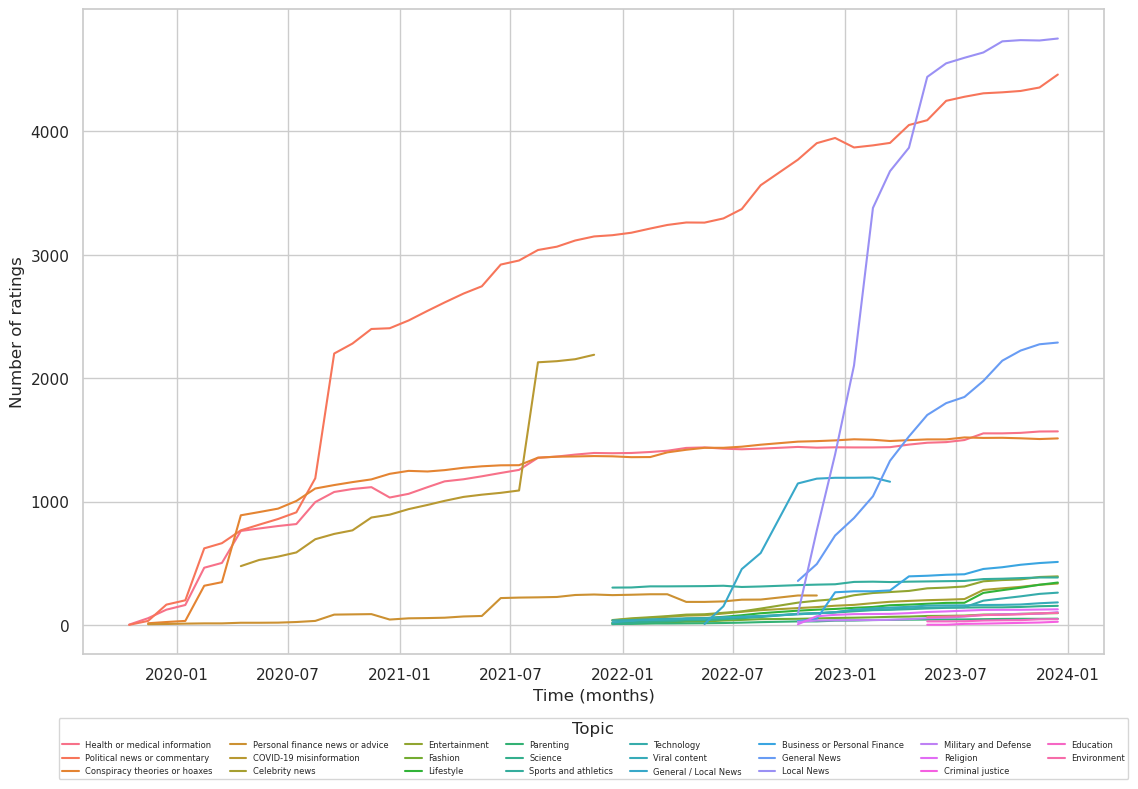

In [ ]:
plt.figure(figsize=(12, 8))
sns.lineplot(x="file_date", 
             y="Count", 
             hue="Topic", 
             data=topic_freq)
plt.xlabel("Time (months)")
plt.ylabel("Number of ratings")
plt.legend(title="Topic",
           loc="lower center", 
           bbox_to_anchor=(0.5, -0.2), 
           ncol=8, 
           fontsize=6)
plt.tight_layout()

plt.savefig(join(figures_path, 
                "fa3-topics_over_time.png"),
                dpi=300)
plt.show()

In [ ]:
#show me the max count for health misinformation
topic_freq[topic_freq["Topic"] == "COVID-19 misinformation"]\
    .sort_values("Count", ascending=False)\
    .head(5)

,file_date,Topic,Count
117,2021-11-15 01:00:00,COVID-19 misinformation,2190
112,2021-10-15 01:00:00,COVID-19 misinformation,2154
107,2021-09-15 01:00:00,COVID-19 misinformation,2138
102,2021-08-15 01:00:00,COVID-19 misinformation,2129
97,2021-07-15 01:00:00,COVID-19 misinformation,1090


### By Country

In [ ]:
country_topics = recent_topics_df\
    .groupby(["Country", "Topics"])\
    .size()\
    .reset_index(name="Count")

country_topics["Percentage"] = \
    (country_topics["Count"] / recent_topics_df["Domain"].nunique() * 100)\
        .round(2)

country_topics

,Country,Topics,Count,Percentage
0,ALL,Business or Personal Finance,54,0.64
1,ALL,Celebrity news,29,0.34
2,ALL,Conspiracy theories or hoaxes,112,1.33
3,ALL,Criminal justice,2,0.02
4,ALL,Education,2,0.02
...,...,...,...,...
156,US,Religion,58,0.69
157,US,Science,58,0.69
158,US,Sports and athletics,292,3.47
159,US,Technology,59,0.70


In [ ]:
topic_avg = \
    recent_topics_df\
        .groupby(["Country", "Topics"])["Score"]\
        .agg(["mean", "std"])\
        .reset_index()\
        .round(2)

topic_avg.columns = \
    ["Country", "Topics", "Score", "SD"]

topic_descriptives = \
    pd.merge(
        country_topics, 
        topic_avg, 
        on=["Country", "Topics"])

topic_descriptives =\
    topic_descriptives\
    .sort_values(["Country", "Count"], 
                ascending=[True, False])

topic_descriptives.head(2)

,Country,Topics,Count,Percentage,Score,SD
11,ALL,Local News,447,5.31,75.63,24.02
14,ALL,Political news or commentary,412,4.90,73.05,25.52


In [ ]:
#which topic has the highest variance?
topics_df\
    .groupby("Topic")["Score"]\
    .var()\
    .reset_index()\
    .sort_values("Score", ascending=False)\
    .head(5)

,Topic,Score
14,Military and Defense,1305.223702
11,Health or medical information,1267.191526
17,Political news or commentary,1011.767216
19,Science,725.881681
18,Religion,722.208965


In [ ]:
#show for topic health information
topic_descriptives[topic_descriptives["Topics"] == "Health or medical information"]

,Country,Topics,Count,Percentage,Score,SD
9,ALL,Health or medical information,124,1.47,77.84,23.07
24,AT,Health or medical information,1,0.01,77.50,NaN
36,AU,Health or medical information,14,0.17,80.46,16.85
53,CA,Health or medical information,36,0.43,91.29,8.51
71,DE,Health or medical information,34,0.40,73.56,33.01
89,FR,Health or medical information,30,0.36,72.07,22.15
108,GB,Health or medical information,38,0.45,89.00,11.25
127,IT,Health or medical information,57,0.68,73.76,21.18
150,US,Health or medical information,672,7.98,62.14,33.81


In [ ]:
topic_descriptives[topic_descriptives["Topics"] == "Political news or commentary"]

,Country,Topics,Count,Percentage,Score,SD
14,ALL,Political news or commentary,412,4.90,73.05,25.52
26,AT,Political news or commentary,16,0.19,70.38,31.59
40,AU,Political news or commentary,46,0.55,77.11,19.00
56,CA,Political news or commentary,201,2.39,90.20,13.48
76,DE,Political news or commentary,87,1.03,77.04,29.73
94,FR,Political news or commentary,94,1.12,69.55,23.90
113,GB,Political news or commentary,139,1.65,83.37,18.08
131,IT,Political news or commentary,202,2.40,74.10,20.48
140,NZ,Political news or commentary,11,0.13,87.05,16.04
155,US,Political news or commentary,2413,28.67,53.40,31.15


In [ ]:
topic_descriptives[topic_descriptives["Topics"] == "Military and Defense"]

,Country,Topics,Count,Percentage,Score,SD
12,ALL,Military and Defense,7,0.08,66.71,34.26
74,DE,Military and Defense,2,0.02,100.00,0.00
92,FR,Military and Defense,3,0.04,40.00,42.06
111,GB,Military and Defense,2,0.02,81.00,9.19
153,US,Military and Defense,32,0.38,54.08,41.53


In [ ]:
result_countries = topic_descriptives[topic_descriptives["Country"] != "ALL"]\
        .sort_values("Score", ascending=False)

In [ ]:
result_countries

,Country,Topics,Count,Percentage,Score,SD
106,GB,Fashion,1,0.01,100.00,NaN
74,DE,Military and Defense,2,0.02,100.00,0.00
20,AT,Business or Personal Finance,4,0.05,98.75,2.50
29,AT,Technology,1,0.01,95.00,NaN
75,DE,Parenting,3,0.04,94.17,10.10
...,...,...,...,...,...,...
31,AU,Celebrity news,6,0.07,38.33,47.77
77,DE,Religion,2,0.02,25.00,17.68
65,DE,Criminal justice,1,0.01,20.00,NaN
66,DE,Education,1,0.01,20.00,NaN


In [ ]:
#from result_countries take only bad_topics
bad_topics_countries = result_countries[
    result_countries["Topics"].isin(bad_topics["Topics"])]

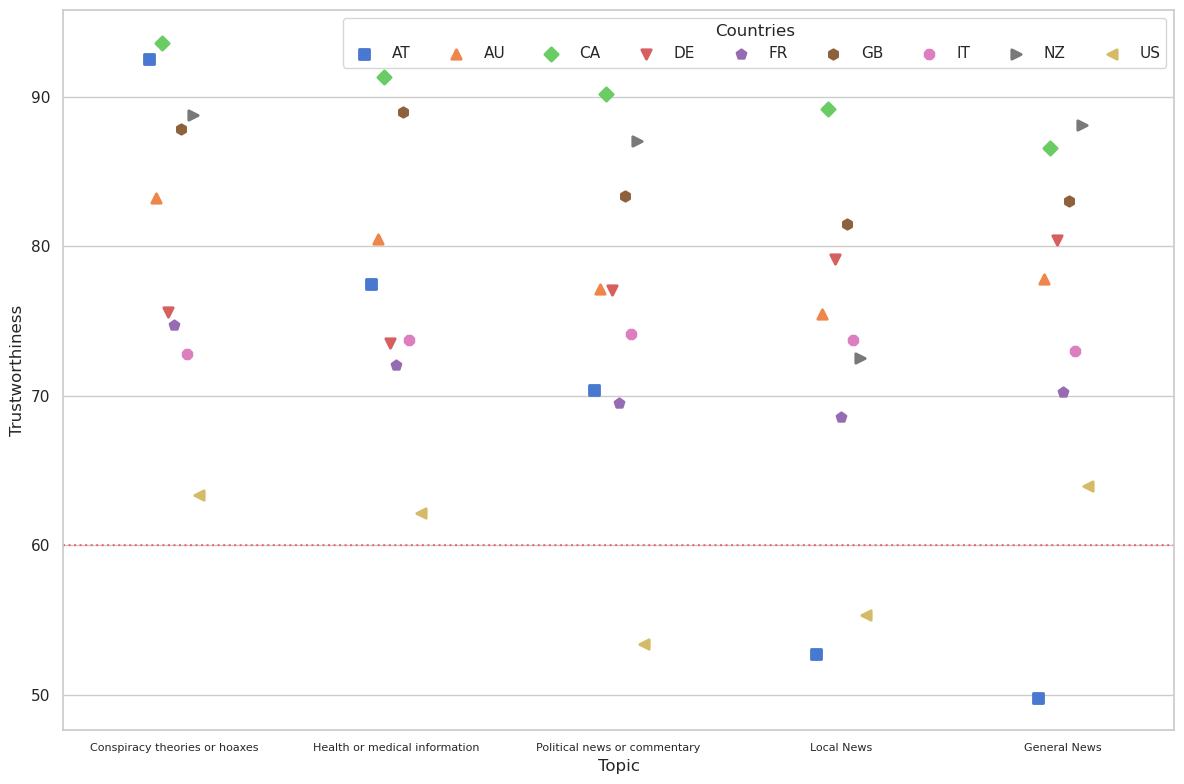

In [ ]:
plt.figure(figsize=(12, 8))
sns.pointplot(x="Topics", 
            y="Score",
            hue="Country",
            hue_order=sorted(bad_topics_countries["Country"].unique()),
            data=bad_topics_countries, 
            dodge=True,
            markers = country_markers,
            join=False,
            palette="muted",
            #order=bad_topics["Topic"].unique()
            )

plt.axhline(y=60,
            color="red", 
            linestyle="dotted", 
            alpha=0.5)

plt.xlabel("Topic")
plt.xticks(fontsize=8)
plt.ylabel("Trustworthiness")
plt.legend(title="Countries",
           loc="upper right", 
           ncol=9)
plt.tight_layout()
plt.savefig(join(figures_path, "f8-topics_score_per_country.png"),
            dpi=300)
plt.show()

### By orientation

In [ ]:
#topics and orientation overlap
topics_orientation = \
    recent_topics_df\
        .groupby(["Orientation", "Topics"])\
        .size()\
        .reset_index(name="Count")

,Orientation,Topics,Count
0,Left,Business or Personal Finance,13
1,Left,Celebrity news,7
2,Left,Conspiracy theories or hoaxes,31
3,Left,Criminal justice,3
4,Left,Entertainment,11
5,Left,Environment,5
6,Left,Fashion,2
7,Left,General News,107
8,Left,Health or medical information,52
9,Left,Lifestyle,4


In [ ]:
mean_scores = \
    recent_topics_df\
        .groupby(["Orientation", "Topics"])["Score"]\
        .agg(["mean", "std"])\
        .reset_index()\
        .round(2)

mean_scores.columns = \
    ["Orientation", "Topics", "Score", "SD"]

topic_orientation_scores = pd.merge(
    topics_orientation, 
    mean_scores, 
    on=["Orientation", "Topics"])

heatmap_count = \
    topic_orientation_scores\
        .pivot_table(
            values="Count", 
            index="Topics", 
            columns="Orientation",
            fill_value=0)

heatmap_score = \
    topic_orientation_scores\
        .pivot_table(
            values="Score", 
            index="Topics", 
            columns="Orientation")

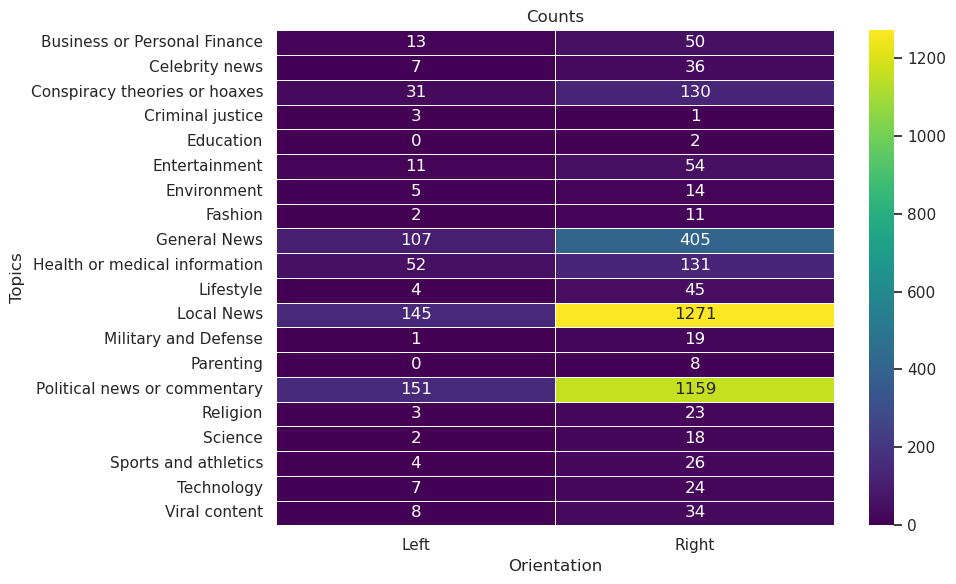

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_count, 
            annot=True, 
            cmap="viridis", 
            fmt="g", 
            linewidths=.5)
plt.title("Counts")
plt.xlabel("Orientation")
plt.ylabel("Topics")

plt.tight_layout()
plt.show()

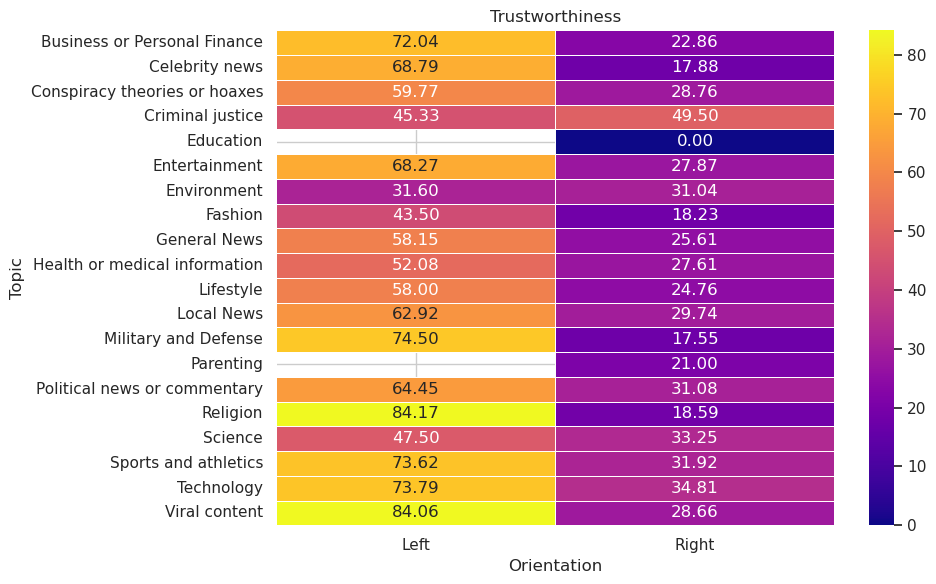

In [ ]:
plt.figure(figsize=(10, 6))

sns.heatmap(heatmap_score, 
            annot=True, 
            cmap="plasma", 
            fmt=".2f", 
            linewidths=.5)
plt.title("Trustworthiness")
plt.xlabel("Orientation")
plt.ylabel("Topic")
plt.tight_layout()
plt.savefig(join(figures_path,
                "f9-topics_orientation.png"),
                dpi=300)
plt.show()

## Other variables

In [ ]:
df_recent.Flags.value_counts().head(10)

hideParty,covid,vacc,hlth,PartisanLocal          1073
covid,abortion,hlth,ukraine,elec,vacc,climate     458
dead                                              166
plag,dead                                         154
ukraine                                           152
elec,covid                                        136
plag                                              111
covid,hlth,vacc                                    76
hideParty                                          72
dead,hoax                                          65
Name: Flags, dtype: int64

<Axes: xlabel='file_date'>

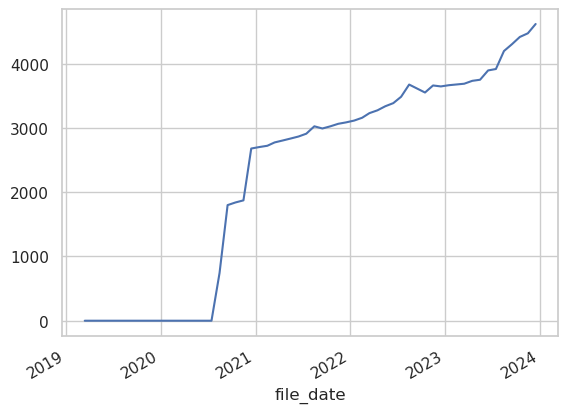

In [ ]:
#create variable with 0 or 1
df15["flags_int"] = \
    df15["Flags"]\
        .notnull()\
        .astype(int)

df15\
    .groupby("file_date")["flags_int"]\
    .sum()\
    .plot(kind="line")

In [ ]:
df15[df15["flags_int"] == 1]\
    .groupby("file_date")["flags_int"]\
    .sum()\
    .head(3)

file_date
2020-08-15 01:00:00     743
2020-09-15 01:00:00    1800
2020-10-15 01:00:00    1841
Name: flags_int, dtype: int64

In [ ]:
df_total["myths"].value_counts()

102431f3-d621-4ba4-ae4b-ab7da59d74d5,7e61e4a4-8409-4290-9ef6-3f54753ec548,33180d69-cfb3-46cb-af1a-3354fb13e887,d7567bf3-d02a-4593-95d8-846c181fe588,79f635e6-94ed-44ed-b7b9-61c35536291c,ef447576-c02b-426c-a961-012c1e14fc80,ef447576-c02b-426c-a961-012c1e14fc80,b5c5d618-dd52-4158-a01e-a3c37c38b35a,d964d1c0-69c5-4ecb-af17-7d513a2aca17,4dc054b4-638c-4932-9ab1-ca1017ef0ade,1d4dda2b-e34e-47d4-88d1-fcf397dab19c,26a6eb22-ec3d-46e2-a99b-7c94ae7c9b6a,59898e32-65cf-46af-9f2c-29d245458bbf,8b42cdd8-7a88-4976-88e3-82e071e6c195,c75fc59a-0358-4fe4-86fe-677d4b8eb493,c75fc59a-0358-4fe4-86fe-677d4b8eb493,70a5b27b-fd14-47b1-809e-a15056900e2a,cf3b4ff0-2264-4c59-b671-0cc00d5b5cfb,bb578c95-03d4-4669-a52c-0d5dff6bda08,bb578c95-03d4-4669-a52c-0d5dff6bda08,0c5b2d3c-f464-478f-a350-4bae0d7427e7,0c5b2d3c-f464-478f-a350-4bae0d7427e7,dad1391e-d967-4812-b417-cabc6e461d39,09320776-1191-4b4e-8c86-3862878e7dca,09320776-1191-4b4e-8c86-3862878e7dca,09320776-1191-4b4e-8c86-3862878e7dca,db6818e3-17ea-4496-af97-d9ed45af792f,e

In [ ]:
df_total["False Narratives"].value_counts()

c008863c-50c8-4800-b18d-afbacc663d82,f0a66c5e-c7f9-4577-a375-26e2d6f5fc65                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [ ]:
df_recent_unique = df_recent.drop_duplicates(subset=["Domain"])
df_recent_unique["Rating"].value_counts(normalize=True)

T    0.618702
N    0.381298
Name: Rating, dtype: float64